# OBTAIN ACTIVATIONS

In [1]:
import torch
import torch.nn as nn
from transformers import AutoModelForCausalLM, AutoTokenizer
from collections import OrderedDict
from utils import *
from tqdm.auto import tqdm
import gc


model = AutoModelForCausalLM.from_pretrained(
    "huggyllama/llama-7b",
    torch_dtype=torch.float16,
    device_map="auto",
)

tokenizer = AutoTokenizer.from_pretrained("huggyllama/llama-7b")

SEQ_LEN = model.config.max_position_embeddings


for p in model.parameters():
    p.requires_grad = False
    
wikitext = get_calib_train_data("wikitext2",
                         tokenizer,
                         seqlen=SEQ_LEN,
                         batch_size=4,
                         nsamples=256+32,
                         seed=42)

model.eval()
model.half()
model.to("cuda")

act = []

def make_hook(name):
    def hook(module, input, output):
        current_pre_act = input[0].detach().to("cpu", non_blocking=True)
        act.append(current_pre_act)
    return hook

layer_hook = "model.layers.2.mlp.down_proj"
hook = model.get_submodule(layer_hook).register_forward_hook(make_hook(layer_hook))

for i, batch in enumerate(tqdm(wikitext)):
    input_ids = batch["input_ids"].to("cuda", non_blocking=True)
    attention_mask = batch["attention_mask"].to("cuda", non_blocking=True)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask, use_cache=False)
        
hook.remove()

# Stack all activations into a single tensor and save them to disk
act = torch.stack(act, dim=0)
# The path of the activations will have the name of the layer hook
torch.save(act, f"matrixes/{layer_hook}_activations.pt")
# Save the weight matrix of the down_proj layer
down_proj_weight = model.get_submodule(layer_hook).weight.data.cpu()
torch.save(down_proj_weight, f"matrixes/{layer_hook}_weight.pt")
print("Activations and weights saved successfully.")
# Clean up
del model
del tokenizer
del wikitext
del act
del down_proj_weight
torch.cuda.empty_cache()
gc.collect()
print("Memory cleaned up.")


/home/mobrrei/miniconda3/envs/svd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


Loading cached dataset from cache/wikitext2_288_2048_42_dict.pt


100%|██████████| 72/72 [01:07<00:00,  1.06it/s]


Activations and weights saved successfully.
Memory cleaned up.


# TESTING GRADIENT METHOD

Training Activations shape: torch.Size([256, 2048, 4096])
Validation Activations shape: torch.Size([32, 2048, 4096])
Loaded weights shape: torch.Size([4096, 4096])
Truncate: 1228


Epoch 1/50: 100%|██████████| 26/26 [00:02<00:00, 11.88it/s, loss=0.0342]


Epoch 1 - Train Loss: 0.0378
Epoch 1 - Validation Loss: 0.0320


Epoch 2/50: 100%|██████████| 26/26 [00:02<00:00, 12.13it/s, loss=0.0312]


Epoch 2 - Train Loss: 0.0329
Epoch 2 - Validation Loss: 0.0300


Epoch 3/50: 100%|██████████| 26/26 [00:02<00:00, 12.16it/s, loss=0.0297]


Epoch 3 - Train Loss: 0.0310
Epoch 3 - Validation Loss: 0.0290


Epoch 4/50: 100%|██████████| 26/26 [00:02<00:00, 12.07it/s, loss=0.0287]


Epoch 4 - Train Loss: 0.0300
Epoch 4 - Validation Loss: 0.0283


Epoch 5/50: 100%|██████████| 26/26 [00:02<00:00, 12.23it/s, loss=0.0281]


Epoch 5 - Train Loss: 0.0293
Epoch 5 - Validation Loss: 0.0279


Epoch 6/50: 100%|██████████| 26/26 [00:02<00:00, 12.23it/s, loss=0.0277]


Epoch 6 - Train Loss: 0.0288
Epoch 6 - Validation Loss: 0.0276


Epoch 7/50: 100%|██████████| 26/26 [00:02<00:00, 12.18it/s, loss=0.0274]


Epoch 7 - Train Loss: 0.0284
Epoch 7 - Validation Loss: 0.0274


Epoch 8/50: 100%|██████████| 26/26 [00:02<00:00, 12.25it/s, loss=0.0271]


Epoch 8 - Train Loss: 0.0282
Epoch 8 - Validation Loss: 0.0273


Epoch 9/50: 100%|██████████| 26/26 [00:02<00:00, 12.21it/s, loss=0.0269]


Epoch 9 - Train Loss: 0.0280
Epoch 9 - Validation Loss: 0.0271


Epoch 10/50: 100%|██████████| 26/26 [00:02<00:00, 12.24it/s, loss=0.0267]


Epoch 10 - Train Loss: 0.0278
Epoch 10 - Validation Loss: 0.0270


Epoch 11/50: 100%|██████████| 26/26 [00:02<00:00, 12.17it/s, loss=0.0265]


Epoch 11 - Train Loss: 0.0276
Epoch 11 - Validation Loss: 0.0269


Epoch 12/50: 100%|██████████| 26/26 [00:02<00:00, 12.23it/s, loss=0.0264]


Epoch 12 - Train Loss: 0.0275
Epoch 12 - Validation Loss: 0.0269


Epoch 13/50: 100%|██████████| 26/26 [00:02<00:00, 12.20it/s, loss=0.0263]


Epoch 13 - Train Loss: 0.0274
Epoch 13 - Validation Loss: 0.0268


Epoch 14/50: 100%|██████████| 26/26 [00:02<00:00, 12.12it/s, loss=0.0262]


Epoch 14 - Train Loss: 0.0273
Epoch 14 - Validation Loss: 0.0267


Epoch 15/50: 100%|██████████| 26/26 [00:02<00:00, 12.14it/s, loss=0.0261]


Epoch 15 - Train Loss: 0.0272
Epoch 15 - Validation Loss: 0.0267


Epoch 16/50: 100%|██████████| 26/26 [00:02<00:00, 12.21it/s, loss=0.0261]


Epoch 16 - Train Loss: 0.0272
Epoch 16 - Validation Loss: 0.0267


Epoch 17/50: 100%|██████████| 26/26 [00:02<00:00, 12.18it/s, loss=0.026] 


Epoch 17 - Train Loss: 0.0271
Epoch 17 - Validation Loss: 0.0266


Epoch 18/50: 100%|██████████| 26/26 [00:02<00:00, 12.11it/s, loss=0.0259]


Epoch 18 - Train Loss: 0.0270
Epoch 18 - Validation Loss: 0.0266


Epoch 19/50: 100%|██████████| 26/26 [00:02<00:00, 12.24it/s, loss=0.0259]


Epoch 19 - Train Loss: 0.0270
Epoch 19 - Validation Loss: 0.0266


Epoch 20/50: 100%|██████████| 26/26 [00:02<00:00, 12.18it/s, loss=0.0259]


Epoch 20 - Train Loss: 0.0270
Epoch 20 - Validation Loss: 0.0265


Epoch 21/50: 100%|██████████| 26/26 [00:02<00:00, 12.19it/s, loss=0.0258]


Epoch 21 - Train Loss: 0.0269
Epoch 21 - Validation Loss: 0.0265


Epoch 22/50: 100%|██████████| 26/26 [00:02<00:00, 12.15it/s, loss=0.0258]


Epoch 22 - Train Loss: 0.0269
Epoch 22 - Validation Loss: 0.0265


Epoch 23/50: 100%|██████████| 26/26 [00:02<00:00, 12.12it/s, loss=0.0258]


Epoch 23 - Train Loss: 0.0269
Epoch 23 - Validation Loss: 0.0265


Epoch 24/50: 100%|██████████| 26/26 [00:02<00:00, 12.18it/s, loss=0.0258]


Epoch 24 - Train Loss: 0.0269
Epoch 24 - Validation Loss: 0.0265


Epoch 25/50: 100%|██████████| 26/26 [00:02<00:00, 12.11it/s, loss=0.0257]


Epoch 25 - Train Loss: 0.0268
Epoch 25 - Validation Loss: 0.0265


Epoch 26/50: 100%|██████████| 26/26 [00:02<00:00, 12.17it/s, loss=0.0257]


Epoch 26 - Train Loss: 0.0268
Epoch 26 - Validation Loss: 0.0265


Epoch 27/50: 100%|██████████| 26/26 [00:02<00:00, 12.12it/s, loss=0.0257]


Epoch 27 - Train Loss: 0.0268
Epoch 27 - Validation Loss: 0.0265


Epoch 28/50: 100%|██████████| 26/26 [00:02<00:00, 12.15it/s, loss=0.0257]


Epoch 28 - Train Loss: 0.0268
Epoch 28 - Validation Loss: 0.0264


Epoch 29/50: 100%|██████████| 26/26 [00:02<00:00, 12.18it/s, loss=0.0257]


Epoch 29 - Train Loss: 0.0268
Epoch 29 - Validation Loss: 0.0264


Epoch 30/50: 100%|██████████| 26/26 [00:02<00:00, 12.22it/s, loss=0.0257]


Epoch 30 - Train Loss: 0.0268
Epoch 30 - Validation Loss: 0.0264


Epoch 31/50: 100%|██████████| 26/26 [00:02<00:00, 12.22it/s, loss=0.0256]


Epoch 31 - Train Loss: 0.0267
Epoch 31 - Validation Loss: 0.0264


Epoch 32/50: 100%|██████████| 26/26 [00:02<00:00, 12.07it/s, loss=0.0256]


Epoch 32 - Train Loss: 0.0267
Epoch 32 - Validation Loss: 0.0264


Epoch 33/50: 100%|██████████| 26/26 [00:02<00:00, 12.08it/s, loss=0.0256]


Epoch 33 - Train Loss: 0.0267
Epoch 33 - Validation Loss: 0.0264


Epoch 34/50: 100%|██████████| 26/26 [00:02<00:00, 12.15it/s, loss=0.0256]


Epoch 34 - Train Loss: 0.0267
Epoch 34 - Validation Loss: 0.0264


Epoch 35/50: 100%|██████████| 26/26 [00:02<00:00, 12.21it/s, loss=0.0256]


Epoch 35 - Train Loss: 0.0267
Epoch 35 - Validation Loss: 0.0264


Epoch 36/50: 100%|██████████| 26/26 [00:02<00:00, 11.88it/s, loss=0.0256]


Epoch 36 - Train Loss: 0.0267
Epoch 36 - Validation Loss: 0.0264


Epoch 37/50: 100%|██████████| 26/26 [00:02<00:00, 12.02it/s, loss=0.0256]


Epoch 37 - Train Loss: 0.0267
Epoch 37 - Validation Loss: 0.0264


Epoch 38/50: 100%|██████████| 26/26 [00:02<00:00, 12.18it/s, loss=0.0256]


Epoch 38 - Train Loss: 0.0267
Epoch 38 - Validation Loss: 0.0264


Epoch 39/50: 100%|██████████| 26/26 [00:02<00:00, 12.08it/s, loss=0.0256]


Epoch 39 - Train Loss: 0.0267
Epoch 39 - Validation Loss: 0.0264


Epoch 40/50: 100%|██████████| 26/26 [00:02<00:00, 12.14it/s, loss=0.0256]


Epoch 40 - Train Loss: 0.0267
Epoch 40 - Validation Loss: 0.0264


Epoch 41/50: 100%|██████████| 26/26 [00:02<00:00, 12.17it/s, loss=0.0255]


Epoch 41 - Train Loss: 0.0267
Epoch 41 - Validation Loss: 0.0264


Epoch 42/50: 100%|██████████| 26/26 [00:02<00:00, 12.10it/s, loss=0.0255]


Epoch 42 - Train Loss: 0.0267
Epoch 42 - Validation Loss: 0.0264


Epoch 43/50: 100%|██████████| 26/26 [00:02<00:00, 12.12it/s, loss=0.0255]


Epoch 43 - Train Loss: 0.0267
Epoch 43 - Validation Loss: 0.0264


Epoch 44/50: 100%|██████████| 26/26 [00:02<00:00, 12.07it/s, loss=0.0255]


Epoch 44 - Train Loss: 0.0266
Epoch 44 - Validation Loss: 0.0264


Epoch 45/50: 100%|██████████| 26/26 [00:02<00:00, 12.14it/s, loss=0.0255]


Epoch 45 - Train Loss: 0.0266
Epoch 45 - Validation Loss: 0.0264


Epoch 46/50: 100%|██████████| 26/26 [00:02<00:00, 12.12it/s, loss=0.0255]


Epoch 46 - Train Loss: 0.0266
Epoch 46 - Validation Loss: 0.0264


Epoch 47/50: 100%|██████████| 26/26 [00:02<00:00, 12.11it/s, loss=0.0255]


Epoch 47 - Train Loss: 0.0266
Epoch 47 - Validation Loss: 0.0263


Epoch 48/50: 100%|██████████| 26/26 [00:02<00:00, 12.14it/s, loss=0.0255]


Epoch 48 - Train Loss: 0.0266
Epoch 48 - Validation Loss: 0.0263


Epoch 49/50: 100%|██████████| 26/26 [00:02<00:00, 12.13it/s, loss=0.0255]


Epoch 49 - Train Loss: 0.0266
Epoch 49 - Validation Loss: 0.0263


Epoch 50/50: 100%|██████████| 26/26 [00:02<00:00, 12.13it/s, loss=0.0255]


Epoch 50 - Train Loss: 0.0266
Epoch 50 - Validation Loss: 0.0263


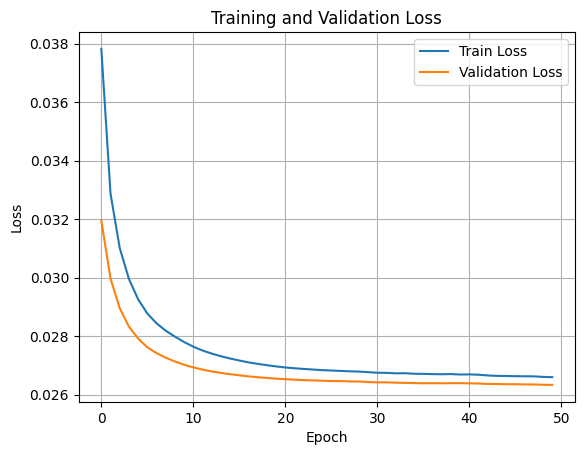

In [ ]:
import torch
from tqdm import tqdm
from modules import SVDLinearLayer
import torch.nn.functional as F
import torch.nn as nn
import pickle

# --- Configuration ---
# Using constants makes the code cleaner and easier to modify.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAYER_HOOK = "model.layers.31.self_attn.q_proj"
ACTIVATIONS_PATH = f"matrixes/{LAYER_HOOK}_activations.pt"
WEIGHTS_PATH = f"matrixes/{LAYER_HOOK}_weight.pt"
IMPORTANCE_PATH = f"grads/llama7b_grads.pkl"

RATIO = 0.6
EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-3
N_SAMPLES_FOR_INIT = 50
BATCH_SIZE = 10
TRAIN_SAMPLES = 256

# --- 1. Efficient Data Loading and Pre-processing ---

# Move weights to the correct device right after loading.
# non_blocking=True can enable faster asynchronous memory copies on CUDA hardware.
W = torch.load(WEIGHTS_PATH).to(DEVICE, non_blocking=True).float()

# It's more memory-efficient to load large tensors to CPU first.
# We will move only the necessary batches to the GPU during training.
pre_act = torch.load(ACTIVATIONS_PATH).float() # (batches, samples_batch, seq_len, features)

# Concat the first two dimensions
pre_act = pre_act.view(pre_act.shape[0] * pre_act.shape[1], pre_act.shape[2], pre_act.shape[3]) # (samples, seq_len, features)

# Shuffle the activations to ensure randomness in training with seed
torch.manual_seed(42)
pre_act = pre_act[torch.randperm(pre_act.size(0))]

pre_act_train = pre_act[:TRAIN_SAMPLES, :, :]  # Use only the first TRAIN_SAMPLES for training
pre_act_val = pre_act[TRAIN_SAMPLES:, :, :]  # Use the rest for validation

del pre_act

print(f"Training Activations shape: {pre_act_train.shape}")
print(f"Validation Activations shape: {pre_act_val.shape}")
print(f"Loaded weights shape: {W.shape}")

# --- 2. Simplified Truncation Calculation ---

out_features, in_features = W.shape
truncate = int(W.shape[0] * W.shape[1] * RATIO / (W.shape[0] + W.shape[1]))
print(f"Truncate: {truncate}")

# --- 3. Memory-Efficient SVD Initialization ---

# Create the initialization data by taking a slice on the CPU first,
# and only then moving the smaller tensor to the GPU.
init_data_slice = pre_act_train[:N_SAMPLES_FOR_INIT, :, :]
svd_layer = SVDLinearLayer(
    W, # weights are already on DEVICE
    truncate,
    bias=None,
    data=init_data_slice.to(DEVICE, non_blocking=True)
).to(DEVICE).train()

og_linear_module = nn.Linear(
    in_features=W.shape[1],
    out_features=W.shape[0],
    bias=False,
    device=DEVICE
)

og_linear_module.weight.data = W.float()
og_linear_module.eval()

# Clean up to free memory immediately.
del init_data_slice
torch.cuda.empty_cache()

loss_fn = nn.MSELoss(reduction="mean")

# Using fused=True can provide a performance boost on compatible CUDA devices.
optimizer = torch.optim.AdamW(
    svd_layer.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, fused=torch.cuda.is_available()
)

# --- 4. Efficient Training Loop ---
train_loss_log = []
val_loss_log = []
for epoch in range(EPOCHS):
    svd_layer.train()
    epoch_loss_log = []
    pbar = tqdm(range(0, pre_act_train.shape[0], BATCH_SIZE), desc=f"Epoch {epoch + 1}/{EPOCHS}")
    
    for i in pbar:
        batch = pre_act_train[i:i + BATCH_SIZE, :, :].to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        
        # Forward pass
        output = svd_layer(batch)
        
        # Compute loss
        loss = loss_fn(output, og_linear_module(batch))
        loss.backward()
        
        # Update weights
        optimizer.step()
        epoch_loss_log.append(loss.item())
        
        pbar.set_postfix({"loss": loss.item()})
    train_loss_log.append(sum(epoch_loss_log) / len(epoch_loss_log))
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss_log[-1]:.4f}")
    svd_layer.eval()
    with torch.no_grad():
        val_loss = loss_fn(svd_layer(pre_act_val.to(DEVICE, non_blocking=True)), og_linear_module(pre_act_val.to(DEVICE, non_blocking=True)))
        val_loss_log.append(val_loss.item())
        print(f"Epoch {epoch + 1} - Validation Loss: {val_loss.item():.4f}")
        
#Log losses 
import matplotlib.pyplot as plt
plt.plot(train_loss_log, label='Train Loss')
plt.plot(val_loss_log, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

## Shuffle Each Epoch

Training Activations shape: torch.Size([256, 2048, 4096])
Validation Activations shape: torch.Size([32, 2048, 4096])
Loaded weights shape: torch.Size([4096, 4096])
Truncate: 1228


Epoch 1/50: 100%|██████████| 26/26 [00:02<00:00,  9.13it/s, loss=0.0344]


Epoch 1 - Train Loss: 0.0377
Epoch 1 - Validation Loss: 0.0319


Epoch 2/50: 100%|██████████| 26/26 [00:03<00:00,  7.83it/s, loss=0.0319]


Epoch 2 - Train Loss: 0.0328
Epoch 2 - Validation Loss: 0.0299


Epoch 3/50: 100%|██████████| 26/26 [00:03<00:00,  7.86it/s, loss=0.0307]


Epoch 3 - Train Loss: 0.0309
Epoch 3 - Validation Loss: 0.0289


Epoch 4/50: 100%|██████████| 26/26 [00:03<00:00,  7.84it/s, loss=0.0295]


Epoch 4 - Train Loss: 0.0299
Epoch 4 - Validation Loss: 0.0282


Epoch 5/50: 100%|██████████| 26/26 [00:03<00:00,  7.87it/s, loss=0.0291]


Epoch 5 - Train Loss: 0.0292
Epoch 5 - Validation Loss: 0.0278


Epoch 6/50: 100%|██████████| 26/26 [00:03<00:00,  7.83it/s, loss=0.0293]


Epoch 6 - Train Loss: 0.0287
Epoch 6 - Validation Loss: 0.0275


Epoch 7/50: 100%|██████████| 26/26 [00:03<00:00,  7.88it/s, loss=0.0282]


Epoch 7 - Train Loss: 0.0283
Epoch 7 - Validation Loss: 0.0273


Epoch 8/50: 100%|██████████| 26/26 [00:03<00:00,  7.83it/s, loss=0.0244]


Epoch 8 - Train Loss: 0.0280
Epoch 8 - Validation Loss: 0.0271


Epoch 9/50: 100%|██████████| 26/26 [00:03<00:00,  7.87it/s, loss=0.0283]


Epoch 9 - Train Loss: 0.0278
Epoch 9 - Validation Loss: 0.0270


Epoch 10/50: 100%|██████████| 26/26 [00:03<00:00,  7.82it/s, loss=0.0286]


Epoch 10 - Train Loss: 0.0277
Epoch 10 - Validation Loss: 0.0269


Epoch 11/50: 100%|██████████| 26/26 [00:03<00:00,  7.85it/s, loss=0.0266]


Epoch 11 - Train Loss: 0.0276
Epoch 11 - Validation Loss: 0.0269


Epoch 12/50: 100%|██████████| 26/26 [00:03<00:00,  7.83it/s, loss=0.0269]


Epoch 12 - Train Loss: 0.0275
Epoch 12 - Validation Loss: 0.0269


Epoch 13/50: 100%|██████████| 26/26 [00:03<00:00,  7.84it/s, loss=0.0273]


Epoch 13 - Train Loss: 0.0274
Epoch 13 - Validation Loss: 0.0267


Epoch 14/50: 100%|██████████| 26/26 [00:03<00:00,  7.82it/s, loss=0.0279]


Epoch 14 - Train Loss: 0.0272
Epoch 14 - Validation Loss: 0.0267


Epoch 15/50: 100%|██████████| 26/26 [00:03<00:00,  7.81it/s, loss=0.0299]


Epoch 15 - Train Loss: 0.0272
Epoch 15 - Validation Loss: 0.0266


Epoch 16/50: 100%|██████████| 26/26 [00:03<00:00,  7.87it/s, loss=0.0285]


Epoch 16 - Train Loss: 0.0271
Epoch 16 - Validation Loss: 0.0266


Epoch 17/50: 100%|██████████| 26/26 [00:03<00:00,  7.85it/s, loss=0.0261]


Epoch 17 - Train Loss: 0.0270
Epoch 17 - Validation Loss: 0.0265


Epoch 18/50: 100%|██████████| 26/26 [00:03<00:00,  7.83it/s, loss=0.0274]


Epoch 18 - Train Loss: 0.0270
Epoch 18 - Validation Loss: 0.0265


Epoch 19/50: 100%|██████████| 26/26 [00:03<00:00,  7.90it/s, loss=0.0266]


Epoch 19 - Train Loss: 0.0269
Epoch 19 - Validation Loss: 0.0265


Epoch 20/50: 100%|██████████| 26/26 [00:03<00:00,  7.87it/s, loss=0.0257]


Epoch 20 - Train Loss: 0.0269
Epoch 20 - Validation Loss: 0.0265


Epoch 21/50: 100%|██████████| 26/26 [00:03<00:00,  7.80it/s, loss=0.0259]


Epoch 21 - Train Loss: 0.0269
Epoch 21 - Validation Loss: 0.0264


Epoch 22/50: 100%|██████████| 26/26 [00:03<00:00,  7.88it/s, loss=0.0263]


Epoch 22 - Train Loss: 0.0268
Epoch 22 - Validation Loss: 0.0264


Epoch 23/50: 100%|██████████| 26/26 [00:03<00:00,  7.88it/s, loss=0.0261]


Epoch 23 - Train Loss: 0.0268
Epoch 23 - Validation Loss: 0.0264


Epoch 24/50: 100%|██████████| 26/26 [00:03<00:00,  7.84it/s, loss=0.0269]


Epoch 24 - Train Loss: 0.0268
Epoch 24 - Validation Loss: 0.0264


Epoch 25/50: 100%|██████████| 26/26 [00:03<00:00,  7.83it/s, loss=0.0263]


Epoch 25 - Train Loss: 0.0268
Epoch 25 - Validation Loss: 0.0264


Epoch 26/50: 100%|██████████| 26/26 [00:03<00:00,  7.67it/s, loss=0.0268]


Epoch 26 - Train Loss: 0.0268
Epoch 26 - Validation Loss: 0.0264


Epoch 27/50: 100%|██████████| 26/26 [00:03<00:00,  7.83it/s, loss=0.0264]


Epoch 27 - Train Loss: 0.0268
Epoch 27 - Validation Loss: 0.0264


Epoch 28/50: 100%|██████████| 26/26 [00:03<00:00,  7.83it/s, loss=0.0286]


Epoch 28 - Train Loss: 0.0268
Epoch 28 - Validation Loss: 0.0264


Epoch 29/50: 100%|██████████| 26/26 [00:03<00:00,  7.84it/s, loss=0.0264]


Epoch 29 - Train Loss: 0.0267
Epoch 29 - Validation Loss: 0.0264


Epoch 30/50: 100%|██████████| 26/26 [00:03<00:00,  7.81it/s, loss=0.0266]


Epoch 30 - Train Loss: 0.0267
Epoch 30 - Validation Loss: 0.0264


Epoch 31/50: 100%|██████████| 26/26 [00:03<00:00,  7.85it/s, loss=0.0278]


Epoch 31 - Train Loss: 0.0267
Epoch 31 - Validation Loss: 0.0264


Epoch 32/50: 100%|██████████| 26/26 [00:03<00:00,  7.85it/s, loss=0.0271]


Epoch 32 - Train Loss: 0.0267
Epoch 32 - Validation Loss: 0.0264


Epoch 33/50: 100%|██████████| 26/26 [00:03<00:00,  7.86it/s, loss=0.0274]


Epoch 33 - Train Loss: 0.0267
Epoch 33 - Validation Loss: 0.0264


Epoch 34/50: 100%|██████████| 26/26 [00:03<00:00,  7.85it/s, loss=0.0271]


Epoch 34 - Train Loss: 0.0267
Epoch 34 - Validation Loss: 0.0264


Epoch 35/50: 100%|██████████| 26/26 [00:03<00:00,  7.81it/s, loss=0.0269]


Epoch 35 - Train Loss: 0.0267
Epoch 35 - Validation Loss: 0.0263


Epoch 36/50: 100%|██████████| 26/26 [00:03<00:00,  7.83it/s, loss=0.0278]


Epoch 36 - Train Loss: 0.0267
Epoch 36 - Validation Loss: 0.0264


Epoch 37/50: 100%|██████████| 26/26 [00:03<00:00,  7.84it/s, loss=0.0265]


Epoch 37 - Train Loss: 0.0267
Epoch 37 - Validation Loss: 0.0263


Epoch 38/50: 100%|██████████| 26/26 [00:03<00:00,  7.84it/s, loss=0.0278]


Epoch 38 - Train Loss: 0.0267
Epoch 38 - Validation Loss: 0.0264


Epoch 39/50: 100%|██████████| 26/26 [00:03<00:00,  7.84it/s, loss=0.0263]


Epoch 39 - Train Loss: 0.0266
Epoch 39 - Validation Loss: 0.0263


Epoch 40/50: 100%|██████████| 26/26 [00:03<00:00,  7.83it/s, loss=0.0257]


Epoch 40 - Train Loss: 0.0267
Epoch 40 - Validation Loss: 0.0264


Epoch 41/50: 100%|██████████| 26/26 [00:03<00:00,  7.83it/s, loss=0.0266]


Epoch 41 - Train Loss: 0.0267
Epoch 41 - Validation Loss: 0.0264


Epoch 42/50: 100%|██████████| 26/26 [00:03<00:00,  7.83it/s, loss=0.0272]


Epoch 42 - Train Loss: 0.0266
Epoch 42 - Validation Loss: 0.0263


Epoch 43/50: 100%|██████████| 26/26 [00:03<00:00,  7.86it/s, loss=0.0228]


Epoch 43 - Train Loss: 0.0266
Epoch 43 - Validation Loss: 0.0263


Epoch 44/50: 100%|██████████| 26/26 [00:03<00:00,  7.84it/s, loss=0.0266]


Epoch 44 - Train Loss: 0.0266
Epoch 44 - Validation Loss: 0.0263


Epoch 45/50: 100%|██████████| 26/26 [00:03<00:00,  7.86it/s, loss=0.0274]


Epoch 45 - Train Loss: 0.0266
Epoch 45 - Validation Loss: 0.0263


Epoch 46/50: 100%|██████████| 26/26 [00:03<00:00,  7.83it/s, loss=0.0264]


Epoch 46 - Train Loss: 0.0266
Epoch 46 - Validation Loss: 0.0263


Epoch 47/50: 100%|██████████| 26/26 [00:03<00:00,  7.85it/s, loss=0.0264]


Epoch 47 - Train Loss: 0.0266
Epoch 47 - Validation Loss: 0.0263


Epoch 48/50: 100%|██████████| 26/26 [00:03<00:00,  7.82it/s, loss=0.0275]


Epoch 48 - Train Loss: 0.0266
Epoch 48 - Validation Loss: 0.0263


Epoch 49/50: 100%|██████████| 26/26 [00:03<00:00,  7.85it/s, loss=0.0266]


Epoch 49 - Train Loss: 0.0266
Epoch 49 - Validation Loss: 0.0263


Epoch 50/50: 100%|██████████| 26/26 [00:03<00:00,  7.80it/s, loss=0.0288]


Epoch 50 - Train Loss: 0.0266
Epoch 50 - Validation Loss: 0.0263


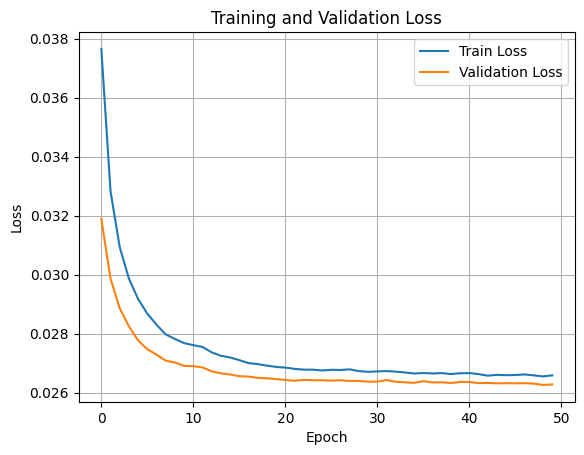

In [1]:
import torch
from tqdm import tqdm
from modules import SVDLinearLayer
import torch.nn.functional as F
import torch.nn as nn
import pickle

# --- Configuration ---
# Using constants makes the code cleaner and easier to modify.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAYER_HOOK = "model.layers.31.self_attn.q_proj"
ACTIVATIONS_PATH = f"matrixes/{LAYER_HOOK}_activations.pt"
WEIGHTS_PATH = f"matrixes/{LAYER_HOOK}_weight.pt"
IMPORTANCE_PATH = f"grads/llama7b_grads.pkl"

RATIO = 0.6
EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-3
N_SAMPLES_FOR_INIT = 50
BATCH_SIZE = 10
TRAIN_SAMPLES = 256

# --- 1. Efficient Data Loading and Pre-processing ---

# Move weights to the correct device right after loading.
# non_blocking=True can enable faster asynchronous memory copies on CUDA hardware.
W = torch.load(WEIGHTS_PATH).to(DEVICE, non_blocking=True).float()

# It's more memory-efficient to load large tensors to CPU first.
# We will move only the necessary batches to the GPU during training.
pre_act = torch.load(ACTIVATIONS_PATH).float() # (batches, samples_batch, seq_len, features)

# Concat the first two dimensions
pre_act = pre_act.view(pre_act.shape[0] * pre_act.shape[1], pre_act.shape[2], pre_act.shape[3]) # (samples, seq_len, features)

# Shuffle the activations to ensure randomness in training with seed
torch.manual_seed(42)
pre_act = pre_act[torch.randperm(pre_act.size(0))]

pre_act_train = pre_act[:TRAIN_SAMPLES, :, :]  # Use only the first TRAIN_SAMPLES for training
pre_act_val = pre_act[TRAIN_SAMPLES:, :, :]  # Use the rest for validation

del pre_act

print(f"Training Activations shape: {pre_act_train.shape}")
print(f"Validation Activations shape: {pre_act_val.shape}")
print(f"Loaded weights shape: {W.shape}")

# --- 2. Simplified Truncation Calculation ---

out_features, in_features = W.shape
truncate = int(W.shape[0] * W.shape[1] * RATIO / (W.shape[0] + W.shape[1]))
print(f"Truncate: {truncate}")

# --- 3. Memory-Efficient SVD Initialization ---

# Create the initialization data by taking a slice on the CPU first,
# and only then moving the smaller tensor to the GPU.
init_data_slice = pre_act_train[:N_SAMPLES_FOR_INIT, :, :]
svd_layer = SVDLinearLayer(
    W, # weights are already on DEVICE
    truncate,
    bias=None,
    data=init_data_slice.to(DEVICE, non_blocking=True)
).to(DEVICE).train()

og_linear_module = nn.Linear(
    in_features=W.shape[1],
    out_features=W.shape[0],
    bias=False,
    device=DEVICE
)

og_linear_module.weight.data = W.float()
og_linear_module.eval()

# Clean up to free memory immediately.
del init_data_slice
torch.cuda.empty_cache()

loss_fn = nn.MSELoss(reduction="mean")

# Using fused=True can provide a performance boost on compatible CUDA devices.
optimizer = torch.optim.AdamW(
    svd_layer.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, fused=torch.cuda.is_available()
)

# --- 4. Efficient Training Loop ---
train_loss_log = []
val_loss_log = []
for epoch in range(EPOCHS):
    svd_layer.train()
    epoch_loss_log = []
    pbar = tqdm(range(0, pre_act_train.shape[0], BATCH_SIZE), desc=f"Epoch {epoch + 1}/{EPOCHS}")
    
    # Shuffle the training data at the start of each epoch
    pre_act_train = pre_act_train[torch.randperm(pre_act_train.size(0))]
    
    for i in pbar:
        batch = pre_act_train[i:i + BATCH_SIZE, :, :].to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        
        # Forward pass
        output = svd_layer(batch)
        
        # Compute loss
        loss = loss_fn(output, og_linear_module(batch))
        loss.backward()
        
        # Update weights
        optimizer.step()
        epoch_loss_log.append(loss.item())
        
        pbar.set_postfix({"loss": loss.item()})
    train_loss_log.append(sum(epoch_loss_log) / len(epoch_loss_log))
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss_log[-1]:.4f}")
    svd_layer.eval()
    with torch.no_grad():
        val_loss = loss_fn(svd_layer(pre_act_val.to(DEVICE, non_blocking=True)), og_linear_module(pre_act_val.to(DEVICE, non_blocking=True)))
        val_loss_log.append(val_loss.item())
        print(f"Epoch {epoch + 1} - Validation Loss: {val_loss.item():.4f}")
        
#Log losses 
import matplotlib.pyplot as plt
plt.plot(train_loss_log, label='Train Loss')
plt.plot(val_loss_log, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# SVD-LLM METHOD

In [8]:
import torch
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAYER_HOOK = "model.layers.31.self_attn.q_proj"
ACTIVATIONS_PATH = f"matrixes/{LAYER_HOOK}_activations.pt"
WEIGHTS_PATH = f"matrixes/{LAYER_HOOK}_weight.pt"

TRAIN_SAMPLES = 256
BATCH_SIZE = 8

# Load activations and weights
pre_act = torch.load(ACTIVATIONS_PATH).float()
W = torch.load(WEIGHTS_PATH).float().to(DEVICE) # OUT FEATURES, IN FEATURES

pre_act = pre_act.view(pre_act.shape[0] * pre_act.shape[1], pre_act.shape[2], pre_act.shape[3]) # (samples, seq_len, features)

torch.manual_seed(42)
pre_act = pre_act[torch.randperm(pre_act.size(0))]

# Use only the first TRAIN_SAMPLES for training
pre_act = pre_act[:TRAIN_SAMPLES, :, :]  # Use only the first TRAIN_SAMPLES for training

# Devide the pre_act into batches
pre_act = pre_act.view(-1, BATCH_SIZE, pre_act.shape[1], pre_act.shape[2])  # (samples, batch_size, seq_len, features)

print(pre_act.shape, W.shape)

raw_scaling_diag_matrix = 0
# Calculate the scaling diagonal matrix

for i in tqdm(range(pre_act.shape[0])):
    inp = pre_act[i].to(DEVICE)
    adds = torch.matmul(inp.transpose(1,2), inp)
    adds_sum = adds.sum(dim=0)
    raw_scaling_diag_matrix += adds_sum
    del adds, adds_sum, inp
    torch.cuda.empty_cache()
    
# Start Cholesky decomposition
raw_scaling_diag_matrix = raw_scaling_diag_matrix.double()
try:
    scaling_diag_matrix = torch.linalg.cholesky(raw_scaling_diag_matrix)
except Exception as e:
    print("Warning: eigen scaling_diag_matrix is not positive!")
    eigenvalues = torch.linalg.eigvalsh(raw_scaling_diag_matrix)
    raw_scaling_diag_matrix += (- eigenvalues[0] + 1e-6) * torch.eye(raw_scaling_diag_matrix.shape[0]).to(dev)
    scaling_diag_matrix = torch.linalg.cholesky(raw_scaling_diag_matrix)
    eigenvalues = None
    del eigenvalues
    
del raw_scaling_diag_matrix
torch.cuda.empty_cache()

try:
    scaling_matrix_inv = torch.linalg.inv(scaling_diag_matrix)
except Exception as e:
    print("Warning: scaling_diag_matrix is not full rank!")
    scaling_diag_matrix += 1e-6 * torch.eye(scaling_diag_matrix.shape[0]).to(DEVICE)
    scaling_matrix_inv = torch.linalg.inv(scaling_diag_matrix)
    
scaling_diag_matrix = scaling_diag_matrix.float()
scaling_matrix_inv = scaling_matrix_inv.float()

torch.cuda.empty_cache()

W_scale = torch.matmul(W, scaling_diag_matrix)
U, S, VT = torch.linalg.svd(W_scale, full_matrices=False)

ratio = 0.6

num_s_after_trunc = int(W.shape[0] * W.shape[1] * ratio / (W.shape[0] + W.shape[1]))

truc_s = S[:num_s_after_trunc]
truc_u = U[:, :num_s_after_trunc]
truc_v = torch.matmul(VT[:num_s_after_trunc, :], scaling_matrix_inv)
truc_sigma = torch.diag(truc_s)

sqrtSigma = torch.sqrt(truc_sigma)
svd_u = torch.matmul(truc_u, sqrtSigma)
svd_v = torch.matmul(sqrtSigma, truc_v)

del U, S, VT, scaling_diag_matrix, scaling_matrix_inv
torch.cuda.empty_cache()

import torch.nn as nn
import torch.nn.functional as F

BATCH_SIZE = 8

pre_act = torch.load(ACTIVATIONS_PATH).float()

pre_act = pre_act.view(pre_act.shape[0] * pre_act.shape[1], pre_act.shape[2], pre_act.shape[3]) # (samples, seq_len, features)

torch.manual_seed(42)
pre_act = pre_act[torch.randperm(pre_act.size(0))]

# Use only the first TRAIN_SAMPLES for training
pre_act_train = pre_act[:TRAIN_SAMPLES, :, :]  # Use only the first TRAIN_SAMPLES for training
pre_act_val = pre_act[TRAIN_SAMPLES:, :, :]  # Use the rest for validation

# Devide the pre_act into batches
pre_act_train = pre_act_train.view(-1, BATCH_SIZE, pre_act_train.shape[1], pre_act_train.shape[2])  # (samples, batch_size, seq_len, features)
pre_act_val = pre_act_val.view(-1, BATCH_SIZE, pre_act_val.shape[1], pre_act_val.shape[2])  # (samples, batch_size, seq_len, features)

og_linear_module = nn.Linear(
    in_features=W.shape[1],
    out_features=W.shape[0],
    bias=False,
    device=DEVICE
)

og_linear_module.weight.data = W.float()
og_linear_module.eval()

svd_llm_linear_module = nn.Sequential(
    nn.Linear(
        in_features=svd_v.shape[1],
        out_features=svd_v.shape[0],
        bias=False,
        device=DEVICE
    ),
    nn.Linear(
        in_features=svd_u.shape[1],
        out_features=svd_u.shape[0],
        bias=False,
        device=DEVICE
    )
)

svd_llm_linear_module[0].weight.data = svd_v.float()
svd_llm_linear_module[1].weight.data = svd_u.float()
svd_llm_linear_module.eval()

# Test the original and SVD-LLM linear modules with the pre_act tensor

loss_log = []
loss_fn = nn.MSELoss(reduction='mean')
for i in tqdm(range(pre_act.shape[0])):
    inp = pre_act[i].to(DEVICE)
    
    og_out = og_linear_module(inp)
    svd_out = svd_llm_linear_module(inp)
    
    loss = loss_fn(og_out, svd_out)
    loss_log.append(loss.item())
    
    del inp, og_out, svd_out
    torch.cuda.empty_cache()
print(f"Train Loss: {sum(loss_log) / len(loss_log)}")

# Calculate the Val loss
val_loss_log = []
for i in tqdm(range(pre_act_val.shape[0])):
    inp = pre_act_val[i].to(DEVICE)
    
    og_out = og_linear_module(inp)
    svd_out = svd_llm_linear_module(inp)
    
    loss = loss_fn(og_out, svd_out)
    val_loss_log.append(loss.item())
    
    del inp, og_out, svd_out
    torch.cuda.empty_cache()
print(f"Validation Loss: {sum(val_loss_log) / len(val_loss_log)}")


torch.Size([32, 8, 2048, 4096]) torch.Size([4096, 4096])


100%|██████████| 288/288 [00:01<00:00, 195.48it/s]


Train Loss: 0.026148973149247468


100%|██████████| 4/4 [00:00<00:00, 19.07it/s]

Validation Loss: 0.026124583091586828


# Alternative Approach of the gradient method

In [3]:
import torch
from tqdm import tqdm
from modules import SVDLinearLayer
import torch.nn.functional as F
import torch.nn as nn
import pickle

# --- Configuration ---
# Updated configuration to reflect the new training loop structure.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAYER_HOOK = "model.layers.31.self_attn.q_proj"
ACTIVATIONS_PATH = f"matrixes/{LAYER_HOOK}_activations.pt"
WEIGHTS_PATH = f"matrixes/{LAYER_HOOK}_weight.pt"
# IMPORTANCE_PATH was defined but not used, so it's commented out.
# IMPORTANCE_PATH = f"grads/llama7b_grads.pkl"

# --- New Training Parameters ---
RATIO = 0.6
RUNS = 5               # Number of distinct data chunks to train on.
SAMPLES_PER_RUN = 34   # The number of samples in each data chunk (acts as a fixed batch).
EPOCHS_PER_RUN = 250    # Number of training epochs to perform on each chunk.
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-3
TRAIN_SAMPLES = 256    # Total samples to use from the dataset for training.

# --- Sanity Check ---
# Ensure the training parameters do not try to access data out of bounds.
assert RUNS * SAMPLES_PER_RUN <= TRAIN_SAMPLES, "RUNS * SAMPLES_PER_RUN exceeds TRAIN_SAMPLES"

# --- 1. Efficient Data Loading and Pre-processing ---

# Move weights to the correct device right after loading.
W = torch.load(WEIGHTS_PATH).to(DEVICE, non_blocking=True).float()

# Load large tensors to CPU first to conserve VRAM.
pre_act = torch.load(ACTIVATIONS_PATH).float()  # (batches, samples_batch, seq_len, features)

# Concatenate the first two dimensions to get a list of samples.
pre_act = pre_act.view(pre_act.shape[0] * pre_act.shape[1], pre_act.shape[2], pre_act.shape[3]) # (samples, seq_len, features)

# Split data into training and validation sets.
pre_act_train = pre_act[:TRAIN_SAMPLES, :, :]
pre_act_val = pre_act[TRAIN_SAMPLES:, :, :]

del pre_act # Free up memory

print(f"Training Activations shape: {pre_act_train.shape}")
print(f"Validation Activations shape: {pre_act_val.shape}")
print(f"Loaded weights shape: {W.shape}")

# --- 2. Simplified Truncation Calculation ---

out_features, in_features = W.shape
truncate = int(out_features * in_features * RATIO / (out_features + in_features))
print(f"Rank after truncation: {truncate}")

# --- 3. Memory-Efficient SVD Initialization ---

# Initialize the SVD layer using the first run's data.
init_data_slice = pre_act_train[:SAMPLES_PER_RUN, :, :]
svd_layer = SVDLinearLayer(
    W, # weights are already on DEVICE
    truncate,
    bias=None,
    data=init_data_slice.to(DEVICE, non_blocking=True)
).to(DEVICE)

# Create the original, non-decomposed linear layer for loss calculation.
og_linear_module = nn.Linear(
    in_features=in_features,
    out_features=out_features,
    bias=False,
    device=DEVICE
)
og_linear_module.weight.data = W.float()
og_linear_module.eval() # Set to evaluation mode as it's our target.

# Clean up to free memory immediately.
del init_data_slice
torch.cuda.empty_cache()

loss_fn = nn.MSELoss(reduction="mean")

# Using fused=True can provide a performance boost on compatible CUDA devices.
optimizer = torch.optim.AdamW(
    svd_layer.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, fused=torch.cuda.is_available()
)

# --- 4. Refactored Training Loop ---
# This loop now iterates through RUNS, training intensively on one block
# of SAMPLES_PER_RUN at a time for EPOCHS_PER_RUN iterations.

train_loss_log = []
val_loss_log = []

for run in range(RUNS):
    print(f"\n--- Starting Run {run + 1}/{RUNS} ---")
    
    # Select the unique data chunk for this run
    start_index = run * SAMPLES_PER_RUN
    end_index = start_index + SAMPLES_PER_RUN
    run_data = pre_act_train[start_index:end_index, :, :].to(DEVICE, non_blocking=True)
    
    # Calculate the target output for this chunk once
    with torch.no_grad():
        target_output = og_linear_module(run_data)

    # Train for EPOCHS_PER_RUN on the selected data chunk
    svd_layer.train()
    run_epoch_loss = []
    pbar = tqdm(range(EPOCHS_PER_RUN), desc=f"Training on Run {run + 1} Data")
    for epoch in pbar:
        optimizer.zero_grad()
        
        # Forward pass
        output = svd_layer(run_data)
        
        # Compute loss against the pre-calculated target
        loss = loss_fn(output, target_output)
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        loss_item = loss.item()
        run_epoch_loss.append(loss_item)
        pbar.set_postfix({"loss": f"{loss_item:.6f}"})

    # Log the average training loss for the entire run
    avg_run_loss = sum(run_epoch_loss) / len(run_epoch_loss)
    train_loss_log.append(avg_run_loss)
    print(f"Run {run + 1} - Average Training Loss: {avg_run_loss:.6f}")

    # Evaluate on the validation set after each full run
    svd_layer.eval()
    with torch.no_grad():
        val_data = pre_act_val.to(DEVICE, non_blocking=True)
        val_output = svd_layer(val_data)
        val_target = og_linear_module(val_data)
        val_loss = loss_fn(val_output, val_target)
        val_loss_log.append(val_loss.item())
        print(f"Run {run + 1} - Validation Loss: {val_loss.item():.6f}")

        # Clean up CUDA memory
        del val_data, val_output, val_target
        torch.cuda.empty_cache()

print("\n--- Training Complete ---")
print(f"Final Training Losses per Run: {train_loss_log}")
print(f"Final Validation Losses per Run: {val_loss_log}")

Training Activations shape: torch.Size([256, 2048, 4096])
Validation Activations shape: torch.Size([32, 2048, 4096])
Loaded weights shape: torch.Size([4096, 4096])
Rank after truncation: 1228

--- Starting Run 1/5 ---


Training on Run 1 Data: 100%|██████████| 250/250 [00:27<00:00,  9.17it/s, loss=0.023412]


Run 1 - Average Training Loss: 0.026050
Run 1 - Validation Loss: 0.027935

--- Starting Run 2/5 ---


Training on Run 2 Data: 100%|██████████| 250/250 [00:27<00:00,  9.06it/s, loss=0.022737]


Run 2 - Average Training Loss: 0.023795
Run 2 - Validation Loss: 0.028480

--- Starting Run 3/5 ---


Training on Run 3 Data: 100%|██████████| 250/250 [00:27<00:00,  9.03it/s, loss=0.022000]


Run 3 - Average Training Loss: 0.023031
Run 3 - Validation Loss: 0.027994

--- Starting Run 4/5 ---


Training on Run 4 Data: 100%|██████████| 250/250 [00:27<00:00,  9.09it/s, loss=0.022708]


Run 4 - Average Training Loss: 0.023602
Run 4 - Validation Loss: 0.027864

--- Starting Run 5/5 ---


Training on Run 5 Data: 100%|██████████| 250/250 [00:27<00:00,  9.05it/s, loss=0.022309]


Run 5 - Average Training Loss: 0.023153
Run 5 - Validation Loss: 0.028196

--- Training Complete ---
Final Training Losses per Run: [0.026050269097089768, 0.023795056462287904, 0.023030835457146168, 0.02360195239633322, 0.023153097212314604]
Final Validation Losses per Run: [0.027935072779655457, 0.02848004177212715, 0.02799449861049652, 0.02786402218043804, 0.0281958170235157]


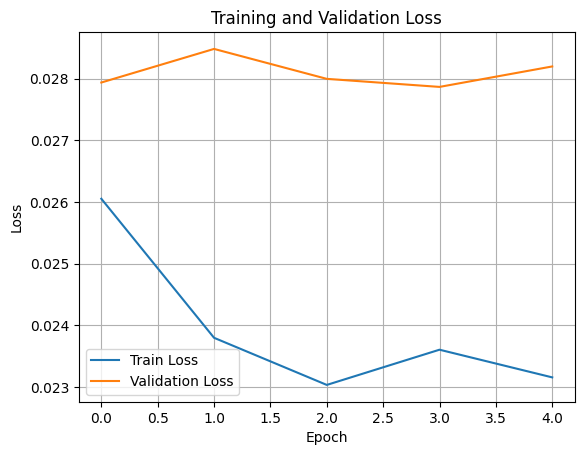

In [4]:
#Log losses 
import matplotlib.pyplot as plt
plt.plot(train_loss_log, label='Train Loss')
plt.plot(val_loss_log, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Testing Normalizations

Training Activations shape: torch.Size([256, 2048, 4096])
Validation Activations shape: torch.Size([32, 2048, 4096])
Loaded weights shape: torch.Size([4096, 4096])
Truncate: 1228


Epoch 1/50: 100%|██████████| 26/26 [00:01<00:00, 13.56it/s, loss=0.0362]


Epoch 1 - Train Loss: 0.0398
Epoch 1 - Validation Loss: 0.0340


Epoch 2/50: 100%|██████████| 26/26 [00:01<00:00, 13.48it/s, loss=0.0334]


Epoch 2 - Train Loss: 0.0352
Epoch 2 - Validation Loss: 0.0318


Epoch 3/50: 100%|██████████| 26/26 [00:01<00:00, 13.65it/s, loss=0.0318]


Epoch 3 - Train Loss: 0.0332
Epoch 3 - Validation Loss: 0.0306


Epoch 4/50: 100%|██████████| 26/26 [00:01<00:00, 13.35it/s, loss=0.0307]


Epoch 4 - Train Loss: 0.0320
Epoch 4 - Validation Loss: 0.0298


Epoch 5/50: 100%|██████████| 26/26 [00:01<00:00, 13.62it/s, loss=0.0299]


Epoch 5 - Train Loss: 0.0311
Epoch 5 - Validation Loss: 0.0292


Epoch 6/50: 100%|██████████| 26/26 [00:01<00:00, 13.71it/s, loss=0.0293]


Epoch 6 - Train Loss: 0.0304
Epoch 6 - Validation Loss: 0.0288


Epoch 7/50: 100%|██████████| 26/26 [00:01<00:00, 13.30it/s, loss=0.0288]


Epoch 7 - Train Loss: 0.0299
Epoch 7 - Validation Loss: 0.0284


Epoch 8/50: 100%|██████████| 26/26 [00:01<00:00, 13.59it/s, loss=0.0284]


Epoch 8 - Train Loss: 0.0295
Epoch 8 - Validation Loss: 0.0282


Epoch 9/50: 100%|██████████| 26/26 [00:01<00:00, 13.57it/s, loss=0.0281]


Epoch 9 - Train Loss: 0.0291
Epoch 9 - Validation Loss: 0.0279


Epoch 10/50: 100%|██████████| 26/26 [00:01<00:00, 13.57it/s, loss=0.0278]


Epoch 10 - Train Loss: 0.0289
Epoch 10 - Validation Loss: 0.0278


Epoch 11/50: 100%|██████████| 26/26 [00:01<00:00, 13.60it/s, loss=0.0276]


Epoch 11 - Train Loss: 0.0286
Epoch 11 - Validation Loss: 0.0276


Epoch 12/50: 100%|██████████| 26/26 [00:01<00:00, 13.56it/s, loss=0.0274]


Epoch 12 - Train Loss: 0.0284
Epoch 12 - Validation Loss: 0.0275


Epoch 13/50: 100%|██████████| 26/26 [00:01<00:00, 13.59it/s, loss=0.0272]


Epoch 13 - Train Loss: 0.0282
Epoch 13 - Validation Loss: 0.0273


Epoch 14/50: 100%|██████████| 26/26 [00:01<00:00, 13.43it/s, loss=0.027] 


Epoch 14 - Train Loss: 0.0281
Epoch 14 - Validation Loss: 0.0273


Epoch 15/50: 100%|██████████| 26/26 [00:01<00:00, 13.57it/s, loss=0.0269]


Epoch 15 - Train Loss: 0.0279
Epoch 15 - Validation Loss: 0.0272


Epoch 16/50: 100%|██████████| 26/26 [00:01<00:00, 13.48it/s, loss=0.0267]


Epoch 16 - Train Loss: 0.0278
Epoch 16 - Validation Loss: 0.0271


Epoch 17/50: 100%|██████████| 26/26 [00:01<00:00, 13.45it/s, loss=0.0266]


Epoch 17 - Train Loss: 0.0277
Epoch 17 - Validation Loss: 0.0270


Epoch 18/50: 100%|██████████| 26/26 [00:01<00:00, 13.54it/s, loss=0.0265]


Epoch 18 - Train Loss: 0.0276
Epoch 18 - Validation Loss: 0.0269


Epoch 19/50: 100%|██████████| 26/26 [00:01<00:00, 13.62it/s, loss=0.0264]


Epoch 19 - Train Loss: 0.0275
Epoch 19 - Validation Loss: 0.0269


Epoch 20/50: 100%|██████████| 26/26 [00:01<00:00, 13.54it/s, loss=0.0264]


Epoch 20 - Train Loss: 0.0274
Epoch 20 - Validation Loss: 0.0268


Epoch 21/50: 100%|██████████| 26/26 [00:01<00:00, 13.61it/s, loss=0.0263]


Epoch 21 - Train Loss: 0.0274
Epoch 21 - Validation Loss: 0.0268


Epoch 22/50: 100%|██████████| 26/26 [00:01<00:00, 13.59it/s, loss=0.0262]


Epoch 22 - Train Loss: 0.0273
Epoch 22 - Validation Loss: 0.0268


Epoch 23/50: 100%|██████████| 26/26 [00:01<00:00, 13.59it/s, loss=0.0262]


Epoch 23 - Train Loss: 0.0272
Epoch 23 - Validation Loss: 0.0267


Epoch 24/50: 100%|██████████| 26/26 [00:01<00:00, 13.48it/s, loss=0.0261]


Epoch 24 - Train Loss: 0.0272
Epoch 24 - Validation Loss: 0.0267


Epoch 25/50: 100%|██████████| 26/26 [00:01<00:00, 13.54it/s, loss=0.0261]


Epoch 25 - Train Loss: 0.0271
Epoch 25 - Validation Loss: 0.0267


Epoch 26/50: 100%|██████████| 26/26 [00:01<00:00, 13.62it/s, loss=0.026] 


Epoch 26 - Train Loss: 0.0271
Epoch 26 - Validation Loss: 0.0267


Epoch 27/50: 100%|██████████| 26/26 [00:01<00:00, 13.54it/s, loss=0.026] 


Epoch 27 - Train Loss: 0.0271
Epoch 27 - Validation Loss: 0.0266


Epoch 28/50: 100%|██████████| 26/26 [00:01<00:00, 13.59it/s, loss=0.0259]


Epoch 28 - Train Loss: 0.0270
Epoch 28 - Validation Loss: 0.0266


Epoch 29/50: 100%|██████████| 26/26 [00:01<00:00, 13.55it/s, loss=0.0259]


Epoch 29 - Train Loss: 0.0270
Epoch 29 - Validation Loss: 0.0266


Epoch 30/50: 100%|██████████| 26/26 [00:01<00:00, 13.64it/s, loss=0.0259]


Epoch 30 - Train Loss: 0.0270
Epoch 30 - Validation Loss: 0.0266


Epoch 31/50: 100%|██████████| 26/26 [00:01<00:00, 13.54it/s, loss=0.0259]


Epoch 31 - Train Loss: 0.0270
Epoch 31 - Validation Loss: 0.0266


Epoch 32/50: 100%|██████████| 26/26 [00:01<00:00, 13.53it/s, loss=0.0258]


Epoch 32 - Train Loss: 0.0269
Epoch 32 - Validation Loss: 0.0265


Epoch 33/50: 100%|██████████| 26/26 [00:01<00:00, 13.63it/s, loss=0.0258]


Epoch 33 - Train Loss: 0.0269
Epoch 33 - Validation Loss: 0.0265


Epoch 34/50: 100%|██████████| 26/26 [00:01<00:00, 13.61it/s, loss=0.0257]


Epoch 34 - Train Loss: 0.0268
Epoch 34 - Validation Loss: 0.0265


Epoch 35/50: 100%|██████████| 26/26 [00:01<00:00, 13.59it/s, loss=0.0257]


Epoch 35 - Train Loss: 0.0268
Epoch 35 - Validation Loss: 0.0265


Epoch 36/50: 100%|██████████| 26/26 [00:01<00:00, 13.62it/s, loss=0.0257]


Epoch 36 - Train Loss: 0.0268
Epoch 36 - Validation Loss: 0.0265


Epoch 37/50: 100%|██████████| 26/26 [00:01<00:00, 13.63it/s, loss=0.0257]


Epoch 37 - Train Loss: 0.0268
Epoch 37 - Validation Loss: 0.0265


Epoch 38/50: 100%|██████████| 26/26 [00:01<00:00, 13.55it/s, loss=0.0256]


Epoch 38 - Train Loss: 0.0268
Epoch 38 - Validation Loss: 0.0265


Epoch 39/50: 100%|██████████| 26/26 [00:01<00:00, 13.53it/s, loss=0.0256]


Epoch 39 - Train Loss: 0.0267
Epoch 39 - Validation Loss: 0.0264


Epoch 40/50: 100%|██████████| 26/26 [00:01<00:00, 13.57it/s, loss=0.0256]


Epoch 40 - Train Loss: 0.0267
Epoch 40 - Validation Loss: 0.0264


Epoch 41/50: 100%|██████████| 26/26 [00:01<00:00, 13.58it/s, loss=0.0256]


Epoch 41 - Train Loss: 0.0267
Epoch 41 - Validation Loss: 0.0264


Epoch 42/50: 100%|██████████| 26/26 [00:01<00:00, 13.54it/s, loss=0.0256]


Epoch 42 - Train Loss: 0.0267
Epoch 42 - Validation Loss: 0.0264


Epoch 43/50: 100%|██████████| 26/26 [00:01<00:00, 13.49it/s, loss=0.0256]


Epoch 43 - Train Loss: 0.0267
Epoch 43 - Validation Loss: 0.0264


Epoch 44/50: 100%|██████████| 26/26 [00:01<00:00, 13.50it/s, loss=0.0255]


Epoch 44 - Train Loss: 0.0267
Epoch 44 - Validation Loss: 0.0264


Epoch 45/50: 100%|██████████| 26/26 [00:01<00:00, 13.48it/s, loss=0.0255]


Epoch 45 - Train Loss: 0.0267
Epoch 45 - Validation Loss: 0.0264


Epoch 46/50: 100%|██████████| 26/26 [00:01<00:00, 13.49it/s, loss=0.0255]


Epoch 46 - Train Loss: 0.0267
Epoch 46 - Validation Loss: 0.0264


Epoch 47/50: 100%|██████████| 26/26 [00:01<00:00, 13.51it/s, loss=0.0255]


Epoch 47 - Train Loss: 0.0266
Epoch 47 - Validation Loss: 0.0264


Epoch 48/50: 100%|██████████| 26/26 [00:01<00:00, 13.53it/s, loss=0.0255]


Epoch 48 - Train Loss: 0.0266
Epoch 48 - Validation Loss: 0.0264


Epoch 49/50: 100%|██████████| 26/26 [00:01<00:00, 13.59it/s, loss=0.0255]


Epoch 49 - Train Loss: 0.0266
Epoch 49 - Validation Loss: 0.0264


Epoch 50/50: 100%|██████████| 26/26 [00:01<00:00, 13.56it/s, loss=0.0255]


Epoch 50 - Train Loss: 0.0266
Epoch 50 - Validation Loss: 0.0264


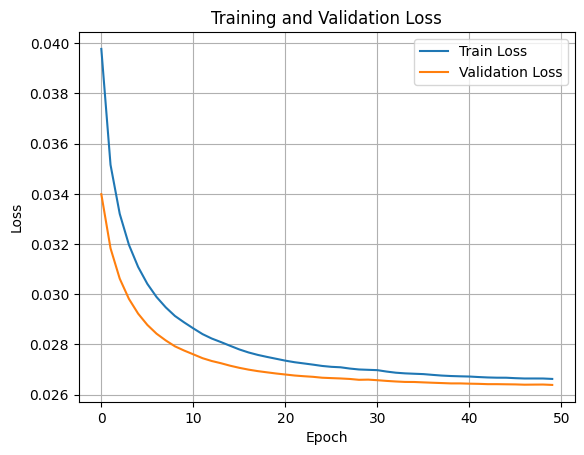

In [7]:
import torch
from tqdm import tqdm
from modules import SVDLinearLayer
import torch.nn.functional as F
import torch.nn as nn
import pickle

# --- Configuration ---
# Using constants makes the code cleaner and easier to modify.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAYER_HOOK = "model.layers.31.self_attn.q_proj"
ACTIVATIONS_PATH = f"matrixes/{LAYER_HOOK}_activations.pt"
WEIGHTS_PATH = f"matrixes/{LAYER_HOOK}_weight.pt"
IMPORTANCE_PATH = f"grads/llama7b_grads.pkl"

RATIO = 0.6
EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-3
N_SAMPLES_FOR_INIT = 50
BATCH_SIZE = 10
TRAIN_SAMPLES = 256

# --- 1. Efficient Data Loading and Pre-processing ---

# Move weights to the correct device right after loading.
# non_blocking=True can enable faster asynchronous memory copies on CUDA hardware.
W = torch.load(WEIGHTS_PATH).to(DEVICE, non_blocking=True).float()

# It's more memory-efficient to load large tensors to CPU first.
# We will move only the necessary batches to the GPU during training.
pre_act = torch.load(ACTIVATIONS_PATH).float() # (batches, samples_batch, seq_len, features)

# Concat the first two dimensions
pre_act = pre_act.view(pre_act.shape[0] * pre_act.shape[1], pre_act.shape[2], pre_act.shape[3]) # (samples, seq_len, features)

torch.manual_seed(42)
pre_act = pre_act[torch.randperm(pre_act.size(0))]

pre_act_train = pre_act[:TRAIN_SAMPLES, :, :]  # Use only the first TRAIN_SAMPLES for training
pre_act_val = pre_act[TRAIN_SAMPLES:, :, :]  # Use the rest for validation

del pre_act

print(f"Training Activations shape: {pre_act_train.shape}")
print(f"Validation Activations shape: {pre_act_val.shape}")
print(f"Loaded weights shape: {W.shape}")

# --- 2. Simplified Truncation Calculation ---

out_features, in_features = W.shape
truncate = int(W.shape[0] * W.shape[1] * RATIO / (W.shape[0] + W.shape[1]))
print(f"Truncate: {truncate}")

# --- 3. Memory-Efficient SVD Initialization ---

# Create the initialization data by taking a slice on the CPU first,
# and only then moving the smaller tensor to the GPU.
init_data_slice = pre_act_train[:N_SAMPLES_FOR_INIT, :, :]

U, S, VT = torch.linalg.svd(W, full_matrices=False)
s_sqrt = torch.diag(torch.sqrt(S))
u_parameter = torch.matmul(U[:, :truncate], s_sqrt[:truncate, :truncate])
vt_parameter = torch.matmul(s_sqrt[:truncate, :truncate], VT[:truncate, :])

svd_layer = nn.Sequential(
    nn.Linear(
        in_features=vt_parameter.shape[1],
        out_features=vt_parameter.shape[0],
        bias=False,
        device=DEVICE
    ),
    nn.Linear(
        in_features=u_parameter.shape[1],
        out_features=u_parameter.shape[0],
        bias=False,
        device=DEVICE
    )
).to(DEVICE).train()

svd_layer[0].weight.data = vt_parameter.float()
svd_layer[1].weight.data = u_parameter.float()


og_linear_module = nn.Linear(
    in_features=W.shape[1],
    out_features=W.shape[0],
    bias=False,
    device=DEVICE
)

og_linear_module.weight.data = W.float()
og_linear_module.eval()

# Clean up to free memory immediately.
del init_data_slice
torch.cuda.empty_cache()

loss_fn = nn.MSELoss(reduction="mean")

# Using fused=True can provide a performance boost on compatible CUDA devices.
optimizer = torch.optim.AdamW(
    svd_layer.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, fused=torch.cuda.is_available()
)

# --- 4. Efficient Training Loop ---
train_loss_log = []
val_loss_log = []
for epoch in range(EPOCHS):
    svd_layer.train()
    epoch_loss_log = []
    pbar = tqdm(range(0, pre_act_train.shape[0], BATCH_SIZE), desc=f"Epoch {epoch + 1}/{EPOCHS}")
    
    for i in pbar:
        batch = pre_act_train[i:i + BATCH_SIZE, :, :].to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        
        # Forward pass
        output = svd_layer(batch)
        
        # Compute loss
        loss = loss_fn(output, og_linear_module(batch))
        loss.backward()
        
        # Update weights
        optimizer.step()
        epoch_loss_log.append(loss.item())
        
        pbar.set_postfix({"loss": loss.item()})
    train_loss_log.append(sum(epoch_loss_log) / len(epoch_loss_log))
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss_log[-1]:.4f}")
    svd_layer.eval()
    with torch.no_grad():
        val_loss = loss_fn(svd_layer(pre_act_val.to(DEVICE, non_blocking=True)), og_linear_module(pre_act_val.to(DEVICE, non_blocking=True)))
        val_loss_log.append(val_loss.item())
        print(f"Epoch {epoch + 1} - Validation Loss: {val_loss.item():.4f}")
        
#Log losses 
import matplotlib.pyplot as plt
plt.plot(train_loss_log, label='Train Loss')
plt.plot(val_loss_log, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

## Shuffle each epoch

Training Activations shape: torch.Size([256, 2048, 4096])
Validation Activations shape: torch.Size([32, 2048, 4096])
Loaded weights shape: torch.Size([4096, 4096])
Truncate: 1228


Epoch 1/50: 100%|██████████| 26/26 [00:02<00:00,  9.93it/s, loss=0.0375]


Epoch 1 - Train Loss: 0.0398
Epoch 1 - Validation Loss: 0.0340


Epoch 2/50: 100%|██████████| 26/26 [00:03<00:00,  8.32it/s, loss=0.0331]


Epoch 2 - Train Loss: 0.0352
Epoch 2 - Validation Loss: 0.0318


Epoch 3/50: 100%|██████████| 26/26 [00:03<00:00,  8.40it/s, loss=0.0324]


Epoch 3 - Train Loss: 0.0332
Epoch 3 - Validation Loss: 0.0306


Epoch 4/50: 100%|██████████| 26/26 [00:03<00:00,  8.31it/s, loss=0.0308]


Epoch 4 - Train Loss: 0.0320
Epoch 4 - Validation Loss: 0.0298


Epoch 5/50: 100%|██████████| 26/26 [00:03<00:00,  8.42it/s, loss=0.0301]


Epoch 5 - Train Loss: 0.0311
Epoch 5 - Validation Loss: 0.0292


Epoch 6/50: 100%|██████████| 26/26 [00:03<00:00,  8.35it/s, loss=0.0312]


Epoch 6 - Train Loss: 0.0304
Epoch 6 - Validation Loss: 0.0287


Epoch 7/50: 100%|██████████| 26/26 [00:03<00:00,  8.44it/s, loss=0.0297]


Epoch 7 - Train Loss: 0.0299
Epoch 7 - Validation Loss: 0.0284


Epoch 8/50: 100%|██████████| 26/26 [00:03<00:00,  8.30it/s, loss=0.0296]


Epoch 8 - Train Loss: 0.0295
Epoch 8 - Validation Loss: 0.0281


Epoch 9/50: 100%|██████████| 26/26 [00:03<00:00,  8.39it/s, loss=0.028] 


Epoch 9 - Train Loss: 0.0291
Epoch 9 - Validation Loss: 0.0278


Epoch 10/50: 100%|██████████| 26/26 [00:03<00:00,  8.33it/s, loss=0.0283]


Epoch 10 - Train Loss: 0.0288
Epoch 10 - Validation Loss: 0.0277


Epoch 11/50: 100%|██████████| 26/26 [00:03<00:00,  8.37it/s, loss=0.0291]


Epoch 11 - Train Loss: 0.0286
Epoch 11 - Validation Loss: 0.0275


Epoch 12/50: 100%|██████████| 26/26 [00:03<00:00,  8.30it/s, loss=0.0299]


Epoch 12 - Train Loss: 0.0284
Epoch 12 - Validation Loss: 0.0274


Epoch 13/50: 100%|██████████| 26/26 [00:03<00:00,  8.42it/s, loss=0.0299]


Epoch 13 - Train Loss: 0.0282
Epoch 13 - Validation Loss: 0.0272


Epoch 14/50: 100%|██████████| 26/26 [00:03<00:00,  8.32it/s, loss=0.0283]


Epoch 14 - Train Loss: 0.0280
Epoch 14 - Validation Loss: 0.0271


Epoch 15/50: 100%|██████████| 26/26 [00:03<00:00,  8.39it/s, loss=0.0241]


Epoch 15 - Train Loss: 0.0278
Epoch 15 - Validation Loss: 0.0271


Epoch 16/50: 100%|██████████| 26/26 [00:03<00:00,  8.40it/s, loss=0.0274]


Epoch 16 - Train Loss: 0.0278
Epoch 16 - Validation Loss: 0.0270


Epoch 17/50: 100%|██████████| 26/26 [00:03<00:00,  8.42it/s, loss=0.0285]


Epoch 17 - Train Loss: 0.0277
Epoch 17 - Validation Loss: 0.0269


Epoch 18/50: 100%|██████████| 26/26 [00:03<00:00,  8.30it/s, loss=0.0293]


Epoch 18 - Train Loss: 0.0276
Epoch 18 - Validation Loss: 0.0269


Epoch 19/50: 100%|██████████| 26/26 [00:03<00:00,  8.39it/s, loss=0.0277]


Epoch 19 - Train Loss: 0.0275
Epoch 19 - Validation Loss: 0.0268


Epoch 20/50: 100%|██████████| 26/26 [00:03<00:00,  8.30it/s, loss=0.0303]


Epoch 20 - Train Loss: 0.0274
Epoch 20 - Validation Loss: 0.0268


Epoch 21/50: 100%|██████████| 26/26 [00:03<00:00,  8.32it/s, loss=0.0264]


Epoch 21 - Train Loss: 0.0273
Epoch 21 - Validation Loss: 0.0267


Epoch 22/50: 100%|██████████| 26/26 [00:03<00:00,  8.31it/s, loss=0.0272]


Epoch 22 - Train Loss: 0.0273
Epoch 22 - Validation Loss: 0.0267


Epoch 23/50: 100%|██████████| 26/26 [00:03<00:00,  8.37it/s, loss=0.0227]


Epoch 23 - Train Loss: 0.0271
Epoch 23 - Validation Loss: 0.0267


Epoch 24/50: 100%|██████████| 26/26 [00:03<00:00,  8.32it/s, loss=0.0266]


Epoch 24 - Train Loss: 0.0271
Epoch 24 - Validation Loss: 0.0266


Epoch 25/50: 100%|██████████| 26/26 [00:03<00:00,  8.40it/s, loss=0.0263]


Epoch 25 - Train Loss: 0.0271
Epoch 25 - Validation Loss: 0.0266


Epoch 26/50: 100%|██████████| 26/26 [00:03<00:00,  8.31it/s, loss=0.029] 


Epoch 26 - Train Loss: 0.0271
Epoch 26 - Validation Loss: 0.0266


Epoch 27/50: 100%|██████████| 26/26 [00:03<00:00,  8.39it/s, loss=0.0278]


Epoch 27 - Train Loss: 0.0271
Epoch 27 - Validation Loss: 0.0266


Epoch 28/50: 100%|██████████| 26/26 [00:03<00:00,  8.34it/s, loss=0.0255]


Epoch 28 - Train Loss: 0.0270
Epoch 28 - Validation Loss: 0.0265


Epoch 29/50: 100%|██████████| 26/26 [00:03<00:00,  8.37it/s, loss=0.0276]


Epoch 29 - Train Loss: 0.0270
Epoch 29 - Validation Loss: 0.0265


Epoch 30/50: 100%|██████████| 26/26 [00:03<00:00,  8.37it/s, loss=0.0271]


Epoch 30 - Train Loss: 0.0269
Epoch 30 - Validation Loss: 0.0265


Epoch 31/50: 100%|██████████| 26/26 [00:03<00:00,  8.35it/s, loss=0.0259]


Epoch 31 - Train Loss: 0.0269
Epoch 31 - Validation Loss: 0.0265


Epoch 32/50: 100%|██████████| 26/26 [00:03<00:00,  8.30it/s, loss=0.0266]


Epoch 32 - Train Loss: 0.0269
Epoch 32 - Validation Loss: 0.0265


Epoch 33/50: 100%|██████████| 26/26 [00:03<00:00,  8.36it/s, loss=0.0283]


Epoch 33 - Train Loss: 0.0269
Epoch 33 - Validation Loss: 0.0264


Epoch 34/50: 100%|██████████| 26/26 [00:03<00:00,  8.32it/s, loss=0.0272]


Epoch 34 - Train Loss: 0.0268
Epoch 34 - Validation Loss: 0.0265


Epoch 35/50: 100%|██████████| 26/26 [00:03<00:00,  8.37it/s, loss=0.0272]


Epoch 35 - Train Loss: 0.0268
Epoch 35 - Validation Loss: 0.0264


Epoch 36/50: 100%|██████████| 26/26 [00:03<00:00,  8.37it/s, loss=0.0287]


Epoch 36 - Train Loss: 0.0268
Epoch 36 - Validation Loss: 0.0264


Epoch 37/50: 100%|██████████| 26/26 [00:03<00:00,  8.36it/s, loss=0.0254]


Epoch 37 - Train Loss: 0.0267
Epoch 37 - Validation Loss: 0.0264


Epoch 38/50: 100%|██████████| 26/26 [00:03<00:00,  8.35it/s, loss=0.0259]


Epoch 38 - Train Loss: 0.0267
Epoch 38 - Validation Loss: 0.0264


Epoch 39/50: 100%|██████████| 26/26 [00:03<00:00,  8.36it/s, loss=0.0271]


Epoch 39 - Train Loss: 0.0267
Epoch 39 - Validation Loss: 0.0264


Epoch 40/50: 100%|██████████| 26/26 [00:03<00:00,  8.34it/s, loss=0.028] 


Epoch 40 - Train Loss: 0.0267
Epoch 40 - Validation Loss: 0.0264


Epoch 41/50: 100%|██████████| 26/26 [00:03<00:00,  8.32it/s, loss=0.0271]


Epoch 41 - Train Loss: 0.0267
Epoch 41 - Validation Loss: 0.0264


Epoch 42/50: 100%|██████████| 26/26 [00:03<00:00,  8.33it/s, loss=0.0283]


Epoch 42 - Train Loss: 0.0267
Epoch 42 - Validation Loss: 0.0264


Epoch 43/50: 100%|██████████| 26/26 [00:03<00:00,  8.31it/s, loss=0.026] 


Epoch 43 - Train Loss: 0.0266
Epoch 43 - Validation Loss: 0.0264


Epoch 44/50: 100%|██████████| 26/26 [00:03<00:00,  8.32it/s, loss=0.0265]


Epoch 44 - Train Loss: 0.0266
Epoch 44 - Validation Loss: 0.0263


Epoch 45/50: 100%|██████████| 26/26 [00:03<00:00,  8.35it/s, loss=0.0269]


Epoch 45 - Train Loss: 0.0266
Epoch 45 - Validation Loss: 0.0263


Epoch 46/50: 100%|██████████| 26/26 [00:03<00:00,  8.33it/s, loss=0.0276]


Epoch 46 - Train Loss: 0.0267
Epoch 46 - Validation Loss: 0.0263


Epoch 47/50: 100%|██████████| 26/26 [00:03<00:00,  8.34it/s, loss=0.0229]


Epoch 47 - Train Loss: 0.0266
Epoch 47 - Validation Loss: 0.0263


Epoch 48/50: 100%|██████████| 26/26 [00:03<00:00,  8.33it/s, loss=0.0211]


Epoch 48 - Train Loss: 0.0265
Epoch 48 - Validation Loss: 0.0263


Epoch 49/50: 100%|██████████| 26/26 [00:03<00:00,  8.34it/s, loss=0.0285]


Epoch 49 - Train Loss: 0.0267
Epoch 49 - Validation Loss: 0.0264


Epoch 50/50: 100%|██████████| 26/26 [00:03<00:00,  8.37it/s, loss=0.0259]


Epoch 50 - Train Loss: 0.0266
Epoch 50 - Validation Loss: 0.0263


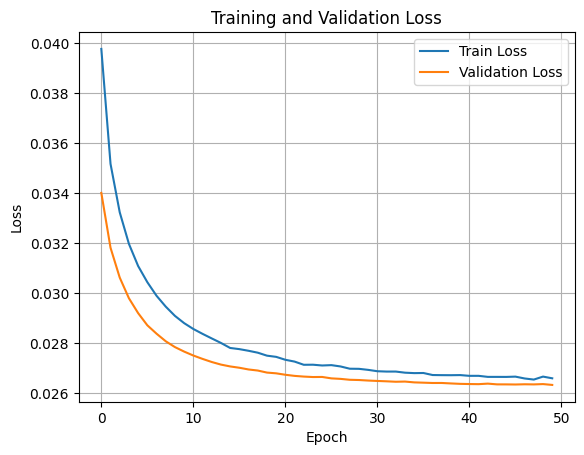

In [ ]:
import torch
from tqdm import tqdm
from modules import SVDLinearLayer
import torch.nn.functional as F
import torch.nn as nn
import pickle

# --- Configuration ---
# Using constants makes the code cleaner and easier to modify.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAYER_HOOK = "model.layers.31.self_attn.q_proj"
ACTIVATIONS_PATH = f"matrixes/{LAYER_HOOK}_activations.pt"
WEIGHTS_PATH = f"matrixes/{LAYER_HOOK}_weight.pt"
IMPORTANCE_PATH = f"grads/llama7b_grads.pkl"

RATIO = 0.6
EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-3
N_SAMPLES_FOR_INIT = 50
BATCH_SIZE = 10
TRAIN_SAMPLES = 256

# --- 1. Efficient Data Loading and Pre-processing ---

# Move weights to the correct device right after loading.
# non_blocking=True can enable faster asynchronous memory copies on CUDA hardware.
W = torch.load(WEIGHTS_PATH).to(DEVICE, non_blocking=True).float()

# It's more memory-efficient to load large tensors to CPU first.
# We will move only the necessary batches to the GPU during training.
pre_act = torch.load(ACTIVATIONS_PATH).float() # (batches, samples_batch, seq_len, features)

# Concat the first two dimensions
pre_act = pre_act.view(pre_act.shape[0] * pre_act.shape[1], pre_act.shape[2], pre_act.shape[3]) # (samples, seq_len, features)

torch.manual_seed(42)
pre_act = pre_act[torch.randperm(pre_act.size(0))]

pre_act_train = pre_act[:TRAIN_SAMPLES, :, :]  # Use only the first TRAIN_SAMPLES for training
pre_act_val = pre_act[TRAIN_SAMPLES:, :, :]  # Use the rest for validation

del pre_act

print(f"Training Activations shape: {pre_act_train.shape}")
print(f"Validation Activations shape: {pre_act_val.shape}")
print(f"Loaded weights shape: {W.shape}")

# --- 2. Simplified Truncation Calculation ---

out_features, in_features = W.shape
truncate = int(W.shape[0] * W.shape[1] * RATIO / (W.shape[0] + W.shape[1]))
print(f"Truncate: {truncate}")

# --- 3. Memory-Efficient SVD Initialization ---

# Create the initialization data by taking a slice on the CPU first,
# and only then moving the smaller tensor to the GPU.
init_data_slice = pre_act_train[:N_SAMPLES_FOR_INIT, :, :]

U, S, VT = torch.linalg.svd(W, full_matrices=False)
s_sqrt = torch.diag(torch.sqrt(S))
u_parameter = torch.matmul(U[:, :truncate], s_sqrt[:truncate, :truncate])
vt_parameter = torch.matmul(s_sqrt[:truncate, :truncate], VT[:truncate, :])

svd_layer = nn.Sequential(
    nn.Linear(
        in_features=vt_parameter.shape[1],
        out_features=vt_parameter.shape[0],
        bias=False,
        device=DEVICE
    ),
    nn.Linear(
        in_features=u_parameter.shape[1],
        out_features=u_parameter.shape[0],
        bias=False,
        device=DEVICE
    )
).to(DEVICE).train()

svd_layer[0].weight.data = vt_parameter.float()
svd_layer[1].weight.data = u_parameter.float()

og_linear_module = nn.Linear(
    in_features=W.shape[1],
    out_features=W.shape[0],
    bias=False,
    device=DEVICE
)

og_linear_module.weight.data = W.float()
og_linear_module.eval()

# Clean up to free memory immediately.
del init_data_slice
torch.cuda.empty_cache()

loss_fn = nn.MSELoss(reduction="mean")

# Using fused=True can provide a performance boost on compatible CUDA devices.
optimizer = torch.optim.AdamW(
    svd_layer.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, fused=torch.cuda.is_available()
)

# --- 4. Efficient Training Loop ---
train_loss_log = []
val_loss_log = []
for epoch in range(EPOCHS):
    svd_layer.train()
    epoch_loss_log = []
    pbar = tqdm(range(0, pre_act_train.shape[0], BATCH_SIZE), desc=f"Epoch {epoch + 1}/{EPOCHS}")
    
    # Shuffle the training data at the start of each epoch
    pre_act_train = pre_act_train[torch.randperm(pre_act_train.size(0))]
    
    for i in pbar:
        batch = pre_act_train[i:i + BATCH_SIZE, :, :].to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        
        # Forward pass
        output = svd_layer(batch)
        
        # Compute loss
        loss = loss_fn(output, og_linear_module(batch))
        loss.backward()
        
        # Update weights
        optimizer.step()
        epoch_loss_log.append(loss.item())
        
        pbar.set_postfix({"loss": loss.item()})
    train_loss_log.append(sum(epoch_loss_log) / len(epoch_loss_log))
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss_log[-1]:.4f}")
    svd_layer.eval()
    with torch.no_grad():
        val_loss = loss_fn(svd_layer(pre_act_val.to(DEVICE, non_blocking=True)), og_linear_module(pre_act_val.to(DEVICE, non_blocking=True)))
        val_loss_log.append(val_loss.item())
        print(f"Epoch {epoch + 1} - Validation Loss: {val_loss.item():.4f}")
        
#Log losses 
import matplotlib.pyplot as plt
plt.plot(train_loss_log, label='Train Loss')
plt.plot(val_loss_log, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# Testing From Scratch

Training Activations shape: torch.Size([256, 2048, 4096])
Validation Activations shape: torch.Size([32, 2048, 4096])
Loaded weights shape: torch.Size([4096, 4096])
Truncate: 1228


Epoch 1/50: 100%|██████████| 26/26 [00:01<00:00, 13.63it/s, loss=0.683]


Epoch 1 - Train Loss: 1.0265
Epoch 1 - Validation Loss: 0.6304


Epoch 2/50: 100%|██████████| 26/26 [00:01<00:00, 13.66it/s, loss=0.441]


Epoch 2 - Train Loss: 0.5333
Epoch 2 - Validation Loss: 0.4226


Epoch 3/50: 100%|██████████| 26/26 [00:01<00:00, 13.66it/s, loss=0.378]


Epoch 3 - Train Loss: 0.4138
Epoch 3 - Validation Loss: 0.3659


Epoch 4/50: 100%|██████████| 26/26 [00:01<00:00, 13.57it/s, loss=0.343]


Epoch 4 - Train Loss: 0.3688
Epoch 4 - Validation Loss: 0.3327


Epoch 5/50: 100%|██████████| 26/26 [00:01<00:00, 13.65it/s, loss=0.316]


Epoch 5 - Train Loss: 0.3380
Epoch 5 - Validation Loss: 0.3072


Epoch 6/50: 100%|██████████| 26/26 [00:01<00:00, 13.65it/s, loss=0.295]


Epoch 6 - Train Loss: 0.3137
Epoch 6 - Validation Loss: 0.2867


Epoch 7/50: 100%|██████████| 26/26 [00:01<00:00, 13.59it/s, loss=0.278]


Epoch 7 - Train Loss: 0.2939
Epoch 7 - Validation Loss: 0.2698


Epoch 8/50: 100%|██████████| 26/26 [00:01<00:00, 13.59it/s, loss=0.262]


Epoch 8 - Train Loss: 0.2772
Epoch 8 - Validation Loss: 0.2554


Epoch 9/50: 100%|██████████| 26/26 [00:01<00:00, 13.68it/s, loss=0.249]


Epoch 9 - Train Loss: 0.2627
Epoch 9 - Validation Loss: 0.2428


Epoch 10/50: 100%|██████████| 26/26 [00:01<00:00, 13.68it/s, loss=0.237]


Epoch 10 - Train Loss: 0.2501
Epoch 10 - Validation Loss: 0.2319


Epoch 11/50: 100%|██████████| 26/26 [00:01<00:00, 13.63it/s, loss=0.227]


Epoch 11 - Train Loss: 0.2390
Epoch 11 - Validation Loss: 0.2221


Epoch 12/50: 100%|██████████| 26/26 [00:01<00:00, 13.55it/s, loss=0.218]


Epoch 12 - Train Loss: 0.2292
Epoch 12 - Validation Loss: 0.2134


Epoch 13/50: 100%|██████████| 26/26 [00:01<00:00, 13.59it/s, loss=0.209]


Epoch 13 - Train Loss: 0.2203
Epoch 13 - Validation Loss: 0.2056


Epoch 14/50: 100%|██████████| 26/26 [00:01<00:00, 13.62it/s, loss=0.202]


Epoch 14 - Train Loss: 0.2122
Epoch 14 - Validation Loss: 0.1984


Epoch 15/50: 100%|██████████| 26/26 [00:01<00:00, 13.55it/s, loss=0.195]


Epoch 15 - Train Loss: 0.2048
Epoch 15 - Validation Loss: 0.1918


Epoch 16/50: 100%|██████████| 26/26 [00:01<00:00, 13.53it/s, loss=0.188]


Epoch 16 - Train Loss: 0.1979
Epoch 16 - Validation Loss: 0.1856


Epoch 17/50: 100%|██████████| 26/26 [00:01<00:00, 13.56it/s, loss=0.182]


Epoch 17 - Train Loss: 0.1915
Epoch 17 - Validation Loss: 0.1799


Epoch 18/50: 100%|██████████| 26/26 [00:01<00:00, 13.56it/s, loss=0.176]


Epoch 18 - Train Loss: 0.1855
Epoch 18 - Validation Loss: 0.1745


Epoch 19/50: 100%|██████████| 26/26 [00:01<00:00, 13.52it/s, loss=0.171]


Epoch 19 - Train Loss: 0.1799
Epoch 19 - Validation Loss: 0.1694


Epoch 20/50: 100%|██████████| 26/26 [00:01<00:00, 13.61it/s, loss=0.166]


Epoch 20 - Train Loss: 0.1746
Epoch 20 - Validation Loss: 0.1646


Epoch 21/50: 100%|██████████| 26/26 [00:01<00:00, 13.61it/s, loss=0.161]


Epoch 21 - Train Loss: 0.1697
Epoch 21 - Validation Loss: 0.1601


Epoch 22/50: 100%|██████████| 26/26 [00:01<00:00, 13.63it/s, loss=0.157]


Epoch 22 - Train Loss: 0.1649
Epoch 22 - Validation Loss: 0.1558


Epoch 23/50: 100%|██████████| 26/26 [00:01<00:00, 13.54it/s, loss=0.153]


Epoch 23 - Train Loss: 0.1605
Epoch 23 - Validation Loss: 0.1518


Epoch 24/50: 100%|██████████| 26/26 [00:01<00:00, 13.58it/s, loss=0.148]


Epoch 24 - Train Loss: 0.1563
Epoch 24 - Validation Loss: 0.1479


Epoch 25/50: 100%|██████████| 26/26 [00:01<00:00, 13.66it/s, loss=0.145]


Epoch 25 - Train Loss: 0.1522
Epoch 25 - Validation Loss: 0.1442


Epoch 26/50: 100%|██████████| 26/26 [00:01<00:00, 13.58it/s, loss=0.141]


Epoch 26 - Train Loss: 0.1484
Epoch 26 - Validation Loss: 0.1407


Epoch 27/50: 100%|██████████| 26/26 [00:01<00:00, 13.51it/s, loss=0.138]


Epoch 27 - Train Loss: 0.1447
Epoch 27 - Validation Loss: 0.1374


Epoch 28/50: 100%|██████████| 26/26 [00:01<00:00, 13.61it/s, loss=0.134]


Epoch 28 - Train Loss: 0.1413
Epoch 28 - Validation Loss: 0.1342


Epoch 29/50: 100%|██████████| 26/26 [00:01<00:00, 13.65it/s, loss=0.131]


Epoch 29 - Train Loss: 0.1379
Epoch 29 - Validation Loss: 0.1312


Epoch 30/50: 100%|██████████| 26/26 [00:01<00:00, 13.65it/s, loss=0.128]


Epoch 30 - Train Loss: 0.1347
Epoch 30 - Validation Loss: 0.1282


Epoch 31/50: 100%|██████████| 26/26 [00:01<00:00, 13.65it/s, loss=0.125]


Epoch 31 - Train Loss: 0.1317
Epoch 31 - Validation Loss: 0.1254


Epoch 32/50: 100%|██████████| 26/26 [00:01<00:00, 13.65it/s, loss=0.122]


Epoch 32 - Train Loss: 0.1287
Epoch 32 - Validation Loss: 0.1227


Epoch 33/50: 100%|██████████| 26/26 [00:01<00:00, 13.48it/s, loss=0.12] 


Epoch 33 - Train Loss: 0.1259
Epoch 33 - Validation Loss: 0.1201


Epoch 34/50: 100%|██████████| 26/26 [00:01<00:00, 13.58it/s, loss=0.117]


Epoch 34 - Train Loss: 0.1232
Epoch 34 - Validation Loss: 0.1176


Epoch 35/50: 100%|██████████| 26/26 [00:01<00:00, 13.58it/s, loss=0.115]


Epoch 35 - Train Loss: 0.1206
Epoch 35 - Validation Loss: 0.1152


Epoch 36/50: 100%|██████████| 26/26 [00:01<00:00, 13.57it/s, loss=0.112]


Epoch 36 - Train Loss: 0.1181
Epoch 36 - Validation Loss: 0.1129


Epoch 37/50: 100%|██████████| 26/26 [00:01<00:00, 13.61it/s, loss=0.11] 


Epoch 37 - Train Loss: 0.1157
Epoch 37 - Validation Loss: 0.1107


Epoch 38/50: 100%|██████████| 26/26 [00:01<00:00, 13.60it/s, loss=0.108]


Epoch 38 - Train Loss: 0.1133
Epoch 38 - Validation Loss: 0.1085


Epoch 39/50: 100%|██████████| 26/26 [00:01<00:00, 13.55it/s, loss=0.106]


Epoch 39 - Train Loss: 0.1111
Epoch 39 - Validation Loss: 0.1064


Epoch 40/50: 100%|██████████| 26/26 [00:01<00:00, 13.51it/s, loss=0.103] 


Epoch 40 - Train Loss: 0.1089
Epoch 40 - Validation Loss: 0.1044


Epoch 41/50: 100%|██████████| 26/26 [00:01<00:00, 13.56it/s, loss=0.101] 


Epoch 41 - Train Loss: 0.1068
Epoch 41 - Validation Loss: 0.1025


Epoch 42/50: 100%|██████████| 26/26 [00:01<00:00, 13.52it/s, loss=0.0995]


Epoch 42 - Train Loss: 0.1047
Epoch 42 - Validation Loss: 0.1006


Epoch 43/50: 100%|██████████| 26/26 [00:01<00:00, 13.60it/s, loss=0.0977]


Epoch 43 - Train Loss: 0.1028
Epoch 43 - Validation Loss: 0.0988


Epoch 44/50: 100%|██████████| 26/26 [00:01<00:00, 13.51it/s, loss=0.0958]


Epoch 44 - Train Loss: 0.1009
Epoch 44 - Validation Loss: 0.0970


Epoch 45/50: 100%|██████████| 26/26 [00:01<00:00, 13.55it/s, loss=0.0941]


Epoch 45 - Train Loss: 0.0990
Epoch 45 - Validation Loss: 0.0953


Epoch 46/50: 100%|██████████| 26/26 [00:01<00:00, 13.57it/s, loss=0.0924]


Epoch 46 - Train Loss: 0.0972
Epoch 46 - Validation Loss: 0.0936


Epoch 47/50: 100%|██████████| 26/26 [00:01<00:00, 13.54it/s, loss=0.0907]


Epoch 47 - Train Loss: 0.0955
Epoch 47 - Validation Loss: 0.0920


Epoch 48/50: 100%|██████████| 26/26 [00:01<00:00, 13.55it/s, loss=0.0891]


Epoch 48 - Train Loss: 0.0938
Epoch 48 - Validation Loss: 0.0904


Epoch 49/50: 100%|██████████| 26/26 [00:01<00:00, 13.57it/s, loss=0.0876]


Epoch 49 - Train Loss: 0.0921
Epoch 49 - Validation Loss: 0.0889


Epoch 50/50: 100%|██████████| 26/26 [00:01<00:00, 13.54it/s, loss=0.0861]


Epoch 50 - Train Loss: 0.0906
Epoch 50 - Validation Loss: 0.0874


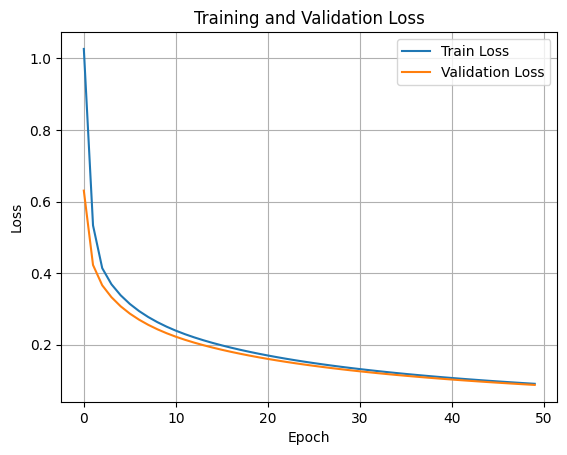

In [ ]:
import torch
from tqdm import tqdm
from modules import SVDLinearLayer
import torch.nn.functional as F
import torch.nn as nn
import pickle

# --- Configuration ---
# Using constants makes the code cleaner and easier to modify.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAYER_HOOK = "model.layers.31.self_attn.q_proj"
ACTIVATIONS_PATH = f"matrixes/{LAYER_HOOK}_activations.pt"
WEIGHTS_PATH = f"matrixes/{LAYER_HOOK}_weight.pt"
IMPORTANCE_PATH = f"grads/llama7b_grads.pkl"

RATIO = 0.6
EPOCHS = 50
LEARNING_RATE = 1e-2
WEIGHT_DECAY = 1e-3
N_SAMPLES_FOR_INIT = 50
BATCH_SIZE = 10
TRAIN_SAMPLES = 256

# --- 1. Efficient Data Loading and Pre-processing ---

# Move weights to the correct device right after loading.
# non_blocking=True can enable faster asynchronous memory copies on CUDA hardware.
W = torch.load(WEIGHTS_PATH).to(DEVICE, non_blocking=True).float()

# It's more memory-efficient to load large tensors to CPU first.
# We will move only the necessary batches to the GPU during training.
pre_act = torch.load(ACTIVATIONS_PATH).float() # (batches, samples_batch, seq_len, features)

# Concat the first two dimensions
pre_act = pre_act.view(pre_act.shape[0] * pre_act.shape[1], pre_act.shape[2], pre_act.shape[3]) # (samples, seq_len, features)

torch.manual_seed(42)
pre_act = pre_act[torch.randperm(pre_act.size(0))]

pre_act_train = pre_act[:TRAIN_SAMPLES, :, :]  # Use only the first TRAIN_SAMPLES for training
pre_act_val = pre_act[TRAIN_SAMPLES:, :, :]  # Use the rest for validation

del pre_act

print(f"Training Activations shape: {pre_act_train.shape}")
print(f"Validation Activations shape: {pre_act_val.shape}")
print(f"Loaded weights shape: {W.shape}")

# --- 2. Simplified Truncation Calculation ---

out_features, in_features = W.shape
truncate = int(W.shape[0] * W.shape[1] * RATIO / (W.shape[0] + W.shape[1]))
print(f"Truncate: {truncate}")

# --- 3. Memory-Efficient SVD Initialization ---

# Create the initialization data by taking a slice on the CPU first,
# and only then moving the smaller tensor to the GPU.
init_data_slice = pre_act_train[:N_SAMPLES_FOR_INIT, :, :]

svd_layer = nn.Sequential(
    nn.Linear(
        in_features=vt_parameter.shape[1],
        out_features=vt_parameter.shape[0],
        bias=False,
        device=DEVICE
    ),
    nn.Linear(
        in_features=u_parameter.shape[1],
        out_features=u_parameter.shape[0],
        bias=False,
        device=DEVICE
    )
).to(DEVICE).train()

og_linear_module = nn.Linear(
    in_features=W.shape[1],
    out_features=W.shape[0],
    bias=False,
    device=DEVICE
)

og_linear_module.weight.data = W.float()
og_linear_module.eval()

# Clean up to free memory immediately.
del init_data_slice
torch.cuda.empty_cache()

loss_fn = nn.MSELoss(reduction="mean")

# Using fused=True can provide a performance boost on compatible CUDA devices.
optimizer = torch.optim.AdamW(
    svd_layer.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, fused=torch.cuda.is_available()
)

# --- 4. Efficient Training Loop ---
train_loss_log = []
val_loss_log = []
for epoch in range(EPOCHS):
    svd_layer.train()
    epoch_loss_log = []
    pbar = tqdm(range(0, pre_act_train.shape[0], BATCH_SIZE), desc=f"Epoch {epoch + 1}/{EPOCHS}")
    
    for i in pbar:
        batch = pre_act_train[i:i + BATCH_SIZE, :, :].to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        
        # Forward pass
        output = svd_layer(batch)
        
        # Compute loss
        loss = loss_fn(output, og_linear_module(batch))
        loss.backward()
        
        # Update weights
        optimizer.step()
        epoch_loss_log.append(loss.item())
        
        pbar.set_postfix({"loss": loss.item()})
    train_loss_log.append(sum(epoch_loss_log) / len(epoch_loss_log))
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss_log[-1]:.4f}")
    svd_layer.eval()
    with torch.no_grad():
        val_loss = loss_fn(svd_layer(pre_act_val.to(DEVICE, non_blocking=True)), og_linear_module(pre_act_val.to(DEVICE, non_blocking=True)))
        val_loss_log.append(val_loss.item())
        print(f"Epoch {epoch + 1} - Validation Loss: {val_loss.item():.4f}")
        
#Log losses 
import matplotlib.pyplot as plt
plt.plot(train_loss_log, label='Train Loss')
plt.plot(val_loss_log, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

# CROSS VALIDATION

## SVD-LLM

Total Activations shape: torch.Size([288, 2048, 4096])
Loaded weights shape: torch.Size([4096, 4096])
--------------------------------------------------
Fold 1/5
--------------------------------------------------
Training Activations shape: torch.Size([230, 2048, 4096])
Validation Activations shape: torch.Size([58, 2048, 4096])
Calculating scaling matrix for the current fold...


Calculating H: 100%|██████████| 29/29 [00:01<00:00, 22.83it/s]


Performing Cholesky decomposition...
Performing SVD...
Evaluating on the validation set...


Validating: 100%|██████████| 8/8 [00:00<00:00, 28.39it/s]


Fold 1 - Validation MSE Loss: 0.02862959
--------------------------------------------------
Fold 2/5
--------------------------------------------------
Training Activations shape: torch.Size([230, 2048, 4096])
Validation Activations shape: torch.Size([58, 2048, 4096])
Calculating scaling matrix for the current fold...


Calculating H: 100%|██████████| 29/29 [00:01<00:00, 23.63it/s]


Performing Cholesky decomposition...
Performing SVD...
Evaluating on the validation set...


Validating: 100%|██████████| 8/8 [00:00<00:00, 28.65it/s]


Fold 2 - Validation MSE Loss: 0.02807433
--------------------------------------------------
Fold 3/5
--------------------------------------------------
Training Activations shape: torch.Size([230, 2048, 4096])
Validation Activations shape: torch.Size([58, 2048, 4096])
Calculating scaling matrix for the current fold...


Calculating H: 100%|██████████| 29/29 [00:01<00:00, 23.38it/s]


Performing Cholesky decomposition...
Performing SVD...
Evaluating on the validation set...


Validating: 100%|██████████| 8/8 [00:00<00:00, 28.43it/s]


Fold 3 - Validation MSE Loss: 0.02838115
--------------------------------------------------
Fold 4/5
--------------------------------------------------
Training Activations shape: torch.Size([231, 2048, 4096])
Validation Activations shape: torch.Size([57, 2048, 4096])
Calculating scaling matrix for the current fold...


Calculating H: 100%|██████████| 29/29 [00:01<00:00, 23.40it/s]


Performing Cholesky decomposition...
Performing SVD...
Evaluating on the validation set...


Validating: 100%|██████████| 8/8 [00:00<00:00, 28.92it/s]


Fold 4 - Validation MSE Loss: 0.02895580
--------------------------------------------------
Fold 5/5
--------------------------------------------------
Training Activations shape: torch.Size([231, 2048, 4096])
Validation Activations shape: torch.Size([57, 2048, 4096])
Calculating scaling matrix for the current fold...


Calculating H: 100%|██████████| 29/29 [00:01<00:00, 23.48it/s]


Performing Cholesky decomposition...
Performing SVD...
Evaluating on the validation set...


Validating: 100%|██████████| 8/8 [00:00<00:00, 29.06it/s]


Fold 5 - Validation MSE Loss: 0.02711381

Cross-Validation Results Summary
Validation Losses per Fold: ['0.02862959', '0.02807433', '0.02838115', '0.02895580', '0.02711381']
Average Validation Loss (MSE): 0.02823094
Standard Deviation of Validation Loss: 0.00062919


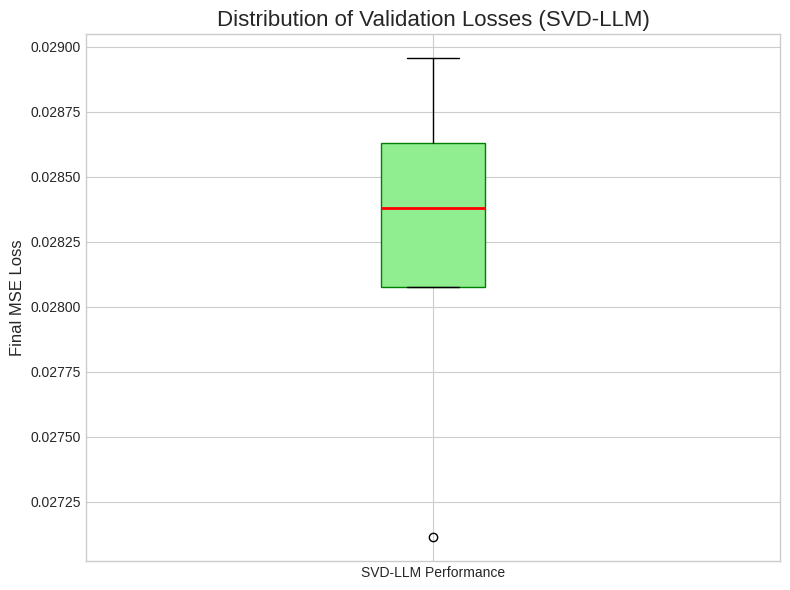

In [3]:
import torch
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAYER_HOOK = "model.layers.31.self_attn.q_proj"
# Note: Ensure these paths are correct for your environment.
# Using placeholder paths for demonstration.
# ACTIVATIONS_PATH = f"matrixes/{LAYER_HOOK}_activations.pt"
# WEIGHTS_PATH = f"matrixes/{LAYER_HOOK}_weight.pt"

RATIO = 0.6
BATCH_SIZE = 8
K_FOLDS = 5 # Number of folds for cross-validation
SEED = 42

# Set seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

# --- 1. Data Loading and Pre-processing ---

# For demonstration purposes, let's create dummy data if files don't exist
try:
    W = torch.load(WEIGHTS_PATH).float().to(DEVICE)
    pre_act = torch.load(ACTIVATIONS_PATH).float()
except FileNotFoundError:
    print("Warning: Data files not found. Creating dummy data for demonstration.")
    IN_FEATURES, OUT_FEATURES = 4096, 4096
    N_SAMPLES, SEQ_LEN = 512, 32
    W = torch.randn(OUT_FEATURES, IN_FEATURES, device=DEVICE).float()
    pre_act = torch.randn(N_SAMPLES // 64, 64, SEQ_LEN, IN_FEATURES).float()

# Reshape and shuffle activations
pre_act = pre_act.view(pre_act.shape[0] * pre_act.shape[1], pre_act.shape[2], pre_act.shape[3])
pre_act = pre_act[torch.randperm(pre_act.size(0))]

print(f"Total Activations shape: {pre_act.shape}")
print(f"Loaded weights shape: {W.shape}")

# --- 2. Cross-Validation Setup ---
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

# Store the validation loss from each fold
fold_validation_losses = []

# --- 3. Cross-Validation Loop ---
for fold, (train_indices, val_indices) in enumerate(kf.split(pre_act)):
    print("-" * 50)
    print(f"Fold {fold + 1}/{K_FOLDS}")
    print("-" * 50)

    # --- Data Splitting for the current fold ---
    pre_act_train = pre_act[train_indices]
    pre_act_val = pre_act[val_indices]
    
    print(f"Training Activations shape: {pre_act_train.shape}")
    print(f"Validation Activations shape: {pre_act_val.shape}")

    # --- a) Calculate Scaling Matrix on Training Data of the Fold ---
    print("Calculating scaling matrix for the current fold...")
    raw_scaling_diag_matrix = 0
    
    # Process in batches to manage memory
    for i in tqdm(range(0, pre_act_train.shape[0], BATCH_SIZE), desc="Calculating H"):
        inp = pre_act_train[i:i+BATCH_SIZE].to(DEVICE)
        # H = X^T * X
        adds = torch.matmul(inp.transpose(-1, -2), inp)
        adds_sum = adds.sum(dim=0)
        raw_scaling_diag_matrix += adds_sum
        del adds, adds_sum, inp
        torch.cuda.empty_cache()

    # --- b) Cholesky Decomposition ---
    print("Performing Cholesky decomposition...")
    raw_scaling_diag_matrix = raw_scaling_diag_matrix.double()
    try:
        scaling_diag_matrix = torch.linalg.cholesky(raw_scaling_diag_matrix)
    except torch.linalg.LinAlgError:
        print("Warning: Scaling matrix is not positive definite. Regularizing...")
        # Add a small identity matrix to ensure positive definiteness
        eigenvalues = torch.linalg.eigvalsh(raw_scaling_diag_matrix)
        regularization = (-eigenvalues[0] + 1e-6) if eigenvalues[0] < 0 else 1e-6
        raw_scaling_diag_matrix += regularization * torch.eye(raw_scaling_diag_matrix.shape[0], device=DEVICE).double()
        scaling_diag_matrix = torch.linalg.cholesky(raw_scaling_diag_matrix)

    # --- c) Calculate Inverse and Scale Weight Matrix ---
    try:
        scaling_matrix_inv = torch.linalg.inv(scaling_diag_matrix)
    except torch.linalg.LinAlgError:
        print("Warning: Scaling matrix is singular. Regularizing before inversion...")
        scaling_diag_matrix += 1e-6 * torch.eye(scaling_diag_matrix.shape[0], device=DEVICE).double()
        scaling_matrix_inv = torch.linalg.inv(scaling_diag_matrix)
    
    scaling_diag_matrix = scaling_diag_matrix.float()
    scaling_matrix_inv = scaling_matrix_inv.float()
    
    W_scaled = torch.matmul(W, scaling_diag_matrix)

    # --- d) SVD on Scaled Weight Matrix ---
    print("Performing SVD...")
    U, S, VT = torch.linalg.svd(W_scaled, full_matrices=False)

    num_s_after_trunc = int(W.shape[1] * W.shape[0] * RATIO / (W.shape[1] + W.shape[0]))

    truc_s = S[:num_s_after_trunc]
    truc_u = U[:, :num_s_after_trunc]
    # "Un-scale" the right singular vectors
    truc_v = torch.matmul(VT[:num_s_after_trunc, :], scaling_matrix_inv)
    
    sqrtSigma = torch.sqrt(torch.diag(truc_s))
    svd_u_factor = torch.matmul(truc_u, sqrtSigma)
    svd_v_factor = torch.matmul(sqrtSigma, truc_v)

    # --- e) Create Original and Decomposed Models ---
    og_linear_module = nn.Linear(W.shape[1], W.shape[0], bias=False, device=DEVICE)
    og_linear_module.weight.data = W.float()
    og_linear_module.eval()

    svd_llm_linear_module = nn.Sequential(
        nn.Linear(svd_v_factor.shape[1], svd_v_factor.shape[0], bias=False, device=DEVICE),
        nn.Linear(svd_u_factor.shape[1], svd_u_factor.shape[0], bias=False, device=DEVICE)
    )
    svd_llm_linear_module[0].weight.data = svd_v_factor.float()
    svd_llm_linear_module[1].weight.data = svd_u_factor.float()
    svd_llm_linear_module.eval()

    # --- f) Evaluate on Validation Set for the Fold ---
    print("Evaluating on the validation set...")
    loss_fn = nn.MSELoss(reduction='mean')
    val_loss = 0.0
    num_val_batches = 0
    with torch.no_grad():
        for i in tqdm(range(0, pre_act_val.shape[0], BATCH_SIZE), desc="Validating"):
            inp = pre_act_val[i:i+BATCH_SIZE].to(DEVICE)
            og_out = og_linear_module(inp)
            svd_out = svd_llm_linear_module(inp)
            val_loss += loss_fn(og_out, svd_out).item()
            num_val_batches += 1
    
    avg_val_loss = val_loss / num_val_batches
    fold_validation_losses.append(avg_val_loss)
    print(f"Fold {fold + 1} - Validation MSE Loss: {avg_val_loss:.8f}")

    # --- g) Clean up for next fold ---
    del raw_scaling_diag_matrix, scaling_diag_matrix, scaling_matrix_inv, W_scaled
    del U, S, VT, truc_u, truc_s, truc_v, sqrtSigma, svd_u_factor, svd_v_factor
    del og_linear_module, svd_llm_linear_module
    torch.cuda.empty_cache()


# --- 4. Results Aggregation and Visualization ---
print("\n" + "="*50)
print("Cross-Validation Results Summary")
print("="*50)

mean_loss = np.mean(fold_validation_losses)
std_loss = np.std(fold_validation_losses)

print(f"Validation Losses per Fold: {[f'{l:.8f}' for l in fold_validation_losses]}")
print(f"Average Validation Loss (MSE): {mean_loss:.8f}")
print(f"Standard Deviation of Validation Loss: {std_loss:.8f}")

# --- Plot: Box Plot of Validation Losses ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(fold_validation_losses, patch_artist=True,
           boxprops=dict(facecolor='lightgreen', color='green'),
           medianprops=dict(color='red', linewidth=2))

ax.set_title('Distribution of Validation Losses (SVD-LLM)', fontsize=16)
ax.set_ylabel('Final MSE Loss', fontsize=12)
ax.set_xticks([1])
ax.set_xticklabels(['SVD-LLM Performance'])
ax.grid(True)
plt.tight_layout()
plt.show()


## Gradient

Total Activations shape: torch.Size([288, 2048, 4096])
Loaded weights shape: torch.Size([4096, 4096])
Rank for truncation: 1228
--------------------------------------------------
Fold 1/5
--------------------------------------------------
Training Activations shape: torch.Size([230, 2048, 4096])
Validation Activations shape: torch.Size([58, 2048, 4096])


--------------------------------------------------
Fold 2/5
--------------------------------------------------
Training Activations shape: torch.Size([230, 2048, 4096])
Validation Activations shape: torch.Size([58, 2048, 4096])


--------------------------------------------------
Fold 3/5
--------------------------------------------------
Training Activations shape: torch.Size([230, 2048, 4096])
Validation Activations shape: torch.Size([58, 2048, 4096])


--------------------------------------------------
Fold 4/5
--------------------------------------------------
Training Activations shape: torch.Size([231, 2048, 4096])
Validation Activations shape: torch.Size([57, 2048, 4096])


--------------------------------------------------
Fold 5/5
--------------------------------------------------
Training Activations shape: torch.Size([231, 2048, 4096])
Validation Activations shape: torch.Size([57, 2048, 4096])



Cross-Validation Results Summary
Final Validation Losses per Fold: ['0.028893', '0.027896', '0.028925', '0.029414', '0.026979']
Average Final Validation Loss: 0.028421
Standard Deviation of Final Validation Loss: 0.000874


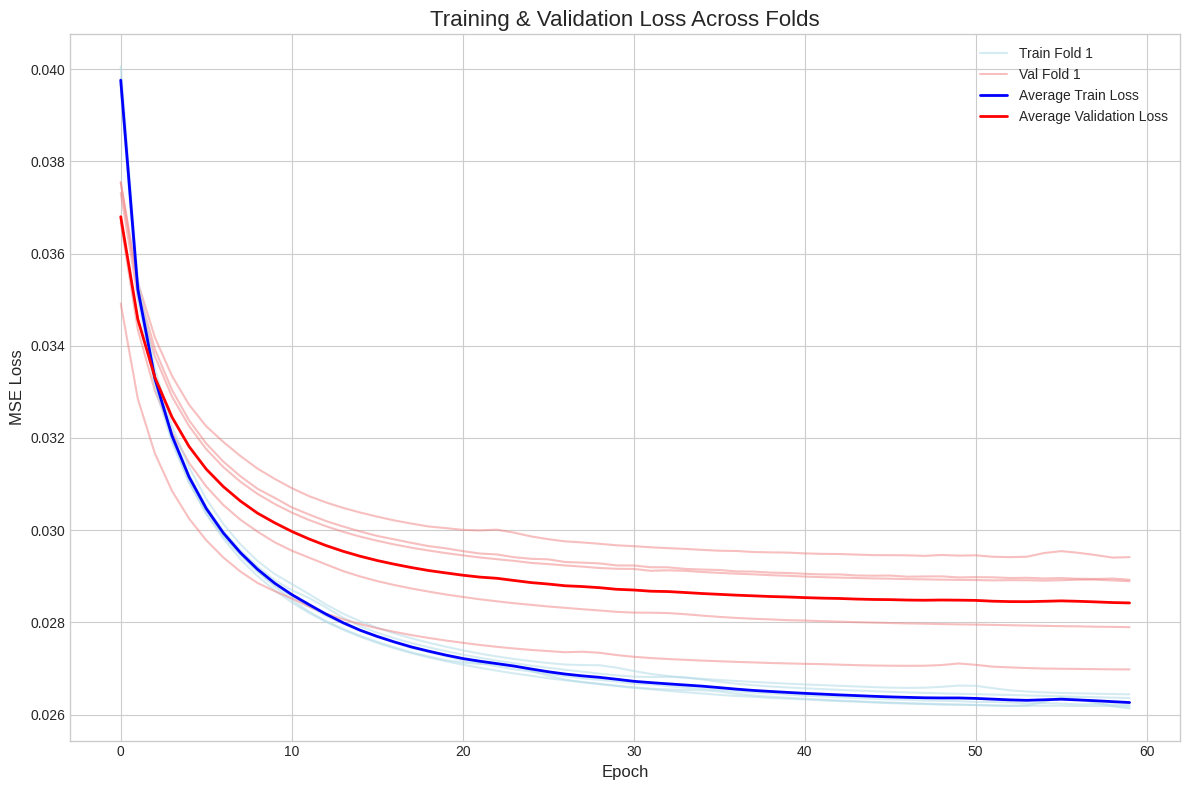

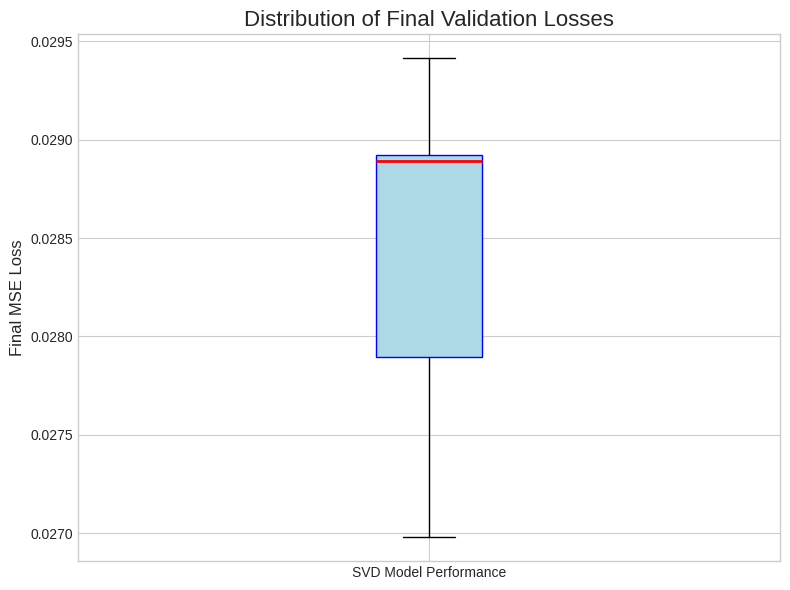

In [4]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import torch.nn as nn
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# --- Configuration ---
# Using constants makes the code cleaner and easier to modify.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAYER_HOOK = "model.layers.31.self_attn.q_proj"
ACTIVATIONS_PATH = f"matrixes/{LAYER_HOOK}_activations.pt"
WEIGHTS_PATH = f"matrixes/{LAYER_HOOK}_weight.pt"
IMPORTANCE_PATH = f"grads/llama7b_grads.pkl"

RATIO = 0.6
EPOCHS = 60
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-3
BATCH_SIZE = 10
K_FOLDS = 5 # Number of folds for cross-validation
SEED = 42

# Set seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)

# --- 1. Data Loading and Pre-processing ---

# For demonstration purposes, let's create dummy data if files don't exist
# In a real scenario, you would have the actual data files.
try:
    W = torch.load(WEIGHTS_PATH).to(DEVICE, non_blocking=True).float()
    # Load to CPU first for memory efficiency
    pre_act = torch.load(ACTIVATIONS_PATH).float()
except FileNotFoundError:
    print("Warning: Data files not found. Creating dummy data for demonstration.")
    # Create plausible shapes for dummy data
    IN_FEATURES, OUT_FEATURES = 4096, 4096
    N_SAMPLES, SEQ_LEN = 512, 32
    W = torch.randn(OUT_FEATURES, IN_FEATURES).to(DEVICE, non_blocking=True).float()
    pre_act = torch.randn(N_SAMPLES // 64, 64, SEQ_LEN, IN_FEATURES).float()


# Concat the first two dimensions: (batches, samples_batch, seq_len, features) -> (samples, seq_len, features)
pre_act = pre_act.view(pre_act.shape[0] * pre_act.shape[1], pre_act.shape[2], pre_act.shape[3])

# Shuffle the entire dataset once before splitting into folds
pre_act = pre_act[torch.randperm(pre_act.size(0))]

print(f"Total Activations shape: {pre_act.shape}")
print(f"Loaded weights shape: {W.shape}")

# --- 2. Simplified Truncation Calculation ---

out_features, in_features = W.shape
truncate = int(out_features * in_features * RATIO / (out_features + in_features))
print(f"Rank for truncation: {truncate}")

# --- 3. Cross-Validation Setup ---
kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

# Store history from all folds to analyze later
fold_histories = []
final_val_losses = []

# --- 4. Cross-Validation Loop ---
for fold, (train_indices, val_indices) in enumerate(kf.split(pre_act)):
    print("-" * 50)
    print(f"Fold {fold + 1}/{K_FOLDS}")
    print("-" * 50)

    # --- Data Splitting for the current fold ---
    pre_act_train = pre_act[train_indices]
    pre_act_val = pre_act[val_indices]

    print(f"Training Activations shape: {pre_act_train.shape}")
    print(f"Validation Activations shape: {pre_act_val.shape}")

    # --- Model and Optimizer Initialization (crucial to do this inside the loop) ---
    # This ensures that for each fold, we start with a fresh, untrained model.
    U, S, VT = torch.linalg.svd(W, full_matrices=False)
    s_sqrt = torch.diag(torch.sqrt(S))
    # Detach parameters from the graph of the original W tensor
    u_parameter = torch.matmul(U[:, :truncate], s_sqrt[:truncate, :truncate]).detach()
    vt_parameter = torch.matmul(s_sqrt[:truncate, :truncate], VT[:truncate, :]).detach()

    svd_layer = nn.Sequential(
        nn.Linear(in_features=vt_parameter.shape[1], out_features=vt_parameter.shape[0], bias=False),
        nn.Linear(in_features=u_parameter.shape[1], out_features=u_parameter.shape[0], bias=False)
    ).to(DEVICE).train()

    svd_layer[0].weight.data = vt_parameter.float()
    svd_layer[1].weight.data = u_parameter.float()

    og_linear_module = nn.Linear(in_features=W.shape[1], out_features=W.shape[0], bias=False, device=DEVICE)
    og_linear_module.weight.data = W.float()
    og_linear_module.eval() # This model doesn't train

    loss_fn = nn.MSELoss(reduction="mean")
    optimizer = torch.optim.AdamW(
        svd_layer.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, fused=torch.cuda.is_available()
    )

    # --- Training Loop for the current fold ---
    train_loss_log = []
    val_loss_log = []

    for epoch in range(EPOCHS):
        svd_layer.train()
        epoch_loss = 0.0
        num_batches = 0
        
        pbar = tqdm(range(0, pre_act_train.shape[0], BATCH_SIZE), desc=f"Epoch {epoch + 1}/{EPOCHS}", leave=False)
        for i in pbar:
            batch = pre_act_train[i:i + BATCH_SIZE].to(DEVICE, non_blocking=True)
            optimizer.zero_grad()
            
            output = svd_layer(batch)
            
            with torch.no_grad():
                target = og_linear_module(batch)

            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
            pbar.set_postfix({"loss": loss.item()})
        
        avg_epoch_loss = epoch_loss / num_batches
        train_loss_log.append(avg_epoch_loss)

        # --- Validation for the current fold ---
        svd_layer.eval()
        with torch.no_grad():
            # Process validation data in batches to avoid OOM errors
            val_loss = 0.0
            num_val_batches = 0
            for i in range(0, pre_act_val.shape[0], BATCH_SIZE):
                val_batch = pre_act_val[i:i+BATCH_SIZE].to(DEVICE, non_blocking=True)
                val_output = svd_layer(val_batch)
                val_target = og_linear_module(val_batch)
                val_loss += loss_fn(val_output, val_target).item()
                num_val_batches += 1

            avg_val_loss = val_loss / num_val_batches
            val_loss_log.append(avg_val_loss)

    fold_histories.append({'train': train_loss_log, 'val': val_loss_log})
    final_val_losses.append(val_loss_log[-1])
    
    # Clean up GPU memory after each fold
    del svd_layer, og_linear_module, optimizer, pre_act_train, pre_act_val
    torch.cuda.empty_cache()


# --- 5. Results Aggregation and Visualization ---
print("\n" + "="*50)
print("Cross-Validation Results Summary")
print("="*50)

mean_loss = np.mean(final_val_losses)
std_loss = np.std(final_val_losses)

print(f"Final Validation Losses per Fold: {[f'{l:.6f}' for l in final_val_losses]}")
print(f"Average Final Validation Loss: {mean_loss:.6f}")
print(f"Standard Deviation of Final Validation Loss: {std_loss:.6f}")

# --- Plot 1: Training and Validation Loss Curves for All Folds ---
plt.style.use('seaborn-v0_8-whitegrid')
fig1, ax1 = plt.subplots(figsize=(12, 8))

# Plot individual fold histories with transparency
for i, history in enumerate(fold_histories):
    ax1.plot(history['train'], color='lightblue', alpha=0.5, label=f'Train Fold {i+1}' if i == 0 else "")
    ax1.plot(history['val'], color='lightcoral', alpha=0.5, label=f'Val Fold {i+1}' if i == 0 else "")

# Calculate and plot average histories
avg_train_loss = np.mean([h['train'] for h in fold_histories], axis=0)
avg_val_loss = np.mean([h['val'] for h in fold_histories], axis=0)

ax1.plot(avg_train_loss, color='blue', linewidth=2, label='Average Train Loss')
ax1.plot(avg_val_loss, color='red', linewidth=2, label='Average Validation Loss')

ax1.set_title('Training & Validation Loss Across Folds', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('MSE Loss', fontsize=12)
ax1.legend()
ax1.grid(True)
plt.tight_layout()
plt.show()


# --- Plot 2: Box Plot of Final Validation Losses ---
fig2, ax2 = plt.subplots(figsize=(8, 6))
ax2.boxplot(final_val_losses, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red', linewidth=2))

ax2.set_title('Distribution of Final Validation Losses', fontsize=16)
ax2.set_ylabel('Final MSE Loss', fontsize=12)
ax2.set_xticks([1])
ax2.set_xticklabels(['SVD Model Performance'])
ax2.grid(True)
plt.tight_layout()
plt.show()


# SUPER WEIGHT

In [8]:
import torch
from tqdm import tqdm
from modules import SVDLinearLayer
import torch.nn.functional as F
import torch.nn as nn
import pickle

# --- Configuration ---
# Using constants makes the code cleaner and easier to modify.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAYER_HOOK = "model.layers.2.mlp.down_proj"
ACTIVATIONS_PATH = f"matrixes/{LAYER_HOOK}_activations.pt"
WEIGHTS_PATH = f"matrixes/{LAYER_HOOK}_weight.pt"
IMPORTANCE_PATH = f"grads/llama7b_grads.pkl"

RATIO = 0.6
EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-3
N_SAMPLES_FOR_INIT = 50
BATCH_SIZE = 10
TRAIN_SAMPLES = 256

# --- 1. Efficient Data Loading and Pre-processing ---

# Move weights to the correct device right after loading.
# non_blocking=True can enable faster asynchronous memory copies on CUDA hardware.
W = torch.load(WEIGHTS_PATH).to(DEVICE, non_blocking=True).float()

# It's more memory-efficient to load large tensors to CPU first.
# We will move only the necessary batches to the GPU during training.
pre_act = torch.load(ACTIVATIONS_PATH).float() # (batches, samples_batch, seq_len, features)

In [14]:
# Apply SVD to W
U, S, Vh = torch.linalg.svd(W.double())

out_features, in_features = W.shape

print(f"Original W shape: {W.shape}")

truncate = min(out_features, in_features)

#Truncate and reconstruct W
U_truncated = U[:, :truncate]
S_truncated = S[:truncate]
Vh_truncated = Vh[:truncate, :]

W_reconstructed = (U_truncated @ torch.diag(S_truncated) @ Vh_truncated).to(DEVICE)

print(f"Reconstructed W shape: {W_reconstructed.shape}")

# Compare reconstructed W with original W
reconstruction_error = F.mse_loss(W_reconstructed, W)
print(f"Reconstruction Error: {reconstruction_error.item():.4f}")


Original W shape: torch.Size([4096, 11008])
Reconstructed W shape: torch.Size([4096, 11008])
Reconstruction Error: 0.0000


In [15]:
print("OG SuperWeight:", W[3968, 7003])
print("Reconstructed SuperWeight:", W_reconstructed[3968, 7003])

OG SuperWeight: tensor(-1.9268, device='cuda:0')
Reconstructed SuperWeight: tensor(-1.9268, device='cuda:0', dtype=torch.float64)


In [ ]:
import torch
from tqdm import tqdm
from modules import SVDLinearLayer
import torch.nn.functional as F
import torch.nn as nn
import pickle

# --- Configuration ---
# Using constants makes the code cleaner and easier to modify.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LAYER_HOOK = "model.layers.31.self_attn.q_proj"
ACTIVATIONS_PATH = f"matrixes/{LAYER_HOOK}_activations.pt"
WEIGHTS_PATH = f"matrixes/{LAYER_HOOK}_weight.pt"
IMPORTANCE_PATH = f"grads/llama7b_grads.pkl"

RATIO = 0.6
EPOCHS = 50
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-3
N_SAMPLES_FOR_INIT = 50
BATCH_SIZE = 10
TRAIN_SAMPLES = 256

PROTECTED_ROW = 3968

# --- 1. Efficient Data Loading and Pre-processing ---

# Move weights to the correct device right after loading.
# non_blocking=True can enable faster asynchronous memory copies on CUDA hardware.
W = torch.load(WEIGHTS_PATH).to(DEVICE, non_blocking=True).float()

# It's more memory-efficient to load large tensors to CPU first.
# We will move only the necessary batches to the GPU during training.
pre_act = torch.load(ACTIVATIONS_PATH).float() # (batches, samples_batch, seq_len, features)

# Concat the first two dimensions
pre_act = pre_act.view(pre_act.shape[0] * pre_act.shape[1], pre_act.shape[2], pre_act.shape[3]) # (samples, seq_len, features)

# Shuffle the activations to ensure randomness in training with seed
torch.manual_seed(42)
pre_act = pre_act[torch.randperm(pre_act.size(0))]

pre_act_train = pre_act[:TRAIN_SAMPLES, :, :]  # Use only the first TRAIN_SAMPLES for training
pre_act_val = pre_act[TRAIN_SAMPLES:, :, :]  # Use the rest for validation

del pre_act

print(f"Training Activations shape: {pre_act_train.shape}")
print(f"Validation Activations shape: {pre_act_val.shape}")
print(f"Loaded weights shape: {W.shape}")

# --- 2. Simplified Truncation Calculation ---

out_features, in_features = W.shape
truncate = int(W.shape[0] * W.shape[1] * RATIO / (W.shape[0] + W.shape[1]))
print(f"Truncate: {truncate}")

# --- 3. Memory-Efficient SVD Initialization ---

# Create the initialization data by taking a slice on the CPU first,
# and only then moving the smaller tensor to the GPU.
init_data_slice = pre_act_train[:N_SAMPLES_FOR_INIT, :, :]
svd_layer = SVDLinearLayer(
    W, # weights are already on DEVICE
    truncate,
    bias=None,
    data=init_data_slice.to(DEVICE, non_blocking=True)
).to(DEVICE).train()

og_linear_module = nn.Linear(
    in_features=W.shape[1],
    out_features=W.shape[0],
    bias=False,
    device=DEVICE
)

og_linear_module.weight.data = W.float()
og_linear_module.eval()

# Clean up to free memory immediately.
del init_data_slice
torch.cuda.empty_cache()

loss_fn = nn.MSELoss(reduction="mean")

# Using fused=True can provide a performance boost on compatible CUDA devices.
optimizer = torch.optim.AdamW(
    svd_layer.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, fused=torch.cuda.is_available()
)

# --- 4. Efficient Training Loop ---
train_loss_log = []
val_loss_log = []
for epoch in range(EPOCHS):
    svd_layer.train()
    epoch_loss_log = []
    pbar = tqdm(range(0, pre_act_train.shape[0], BATCH_SIZE), desc=f"Epoch {epoch + 1}/{EPOCHS}")
    
    # Shuffle the training data at the start of each epoch
    pre_act_train = pre_act_train[torch.randperm(pre_act_train.size(0))]
    
    for i in pbar:
        batch = pre_act_train[i:i + BATCH_SIZE, :, :].to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        
        # Forward pass
        output = svd_layer(batch)
        
        # Compute loss
        loss = loss_fn(output, og_linear_module(batch))
        loss.backward()
        
        # Update weights
        optimizer.step()
        epoch_loss_log.append(loss.item())
        
        pbar.set_postfix({"loss": loss.item()})
    train_loss_log.append(sum(epoch_loss_log) / len(epoch_loss_log))
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss_log[-1]:.4f}")
    svd_layer.eval()
    with torch.no_grad():
        val_loss = loss_fn(svd_layer(pre_act_val.to(DEVICE, non_blocking=True)), og_linear_module(pre_act_val.to(DEVICE, non_blocking=True)))
        val_loss_log.append(val_loss.item())
        print(f"Epoch {epoch + 1} - Validation Loss: {val_loss.item():.4f}")
        
#Log losses 
import matplotlib.pyplot as plt
plt.plot(train_loss_log, label='Train Loss')
plt.plot(val_loss_log, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()